# Utilities

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import xarray as xr
from shapely.geometry.polygon import LinearRing
from EWS_functions import *
import os
import imageio
from tqdm import tqdm
from numpy.linalg import multi_dot
from IPython.display import Image
jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'


# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = ['Arial']
# hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

import statsmodels.api as sm
import scipy.stats as st
from scipy.optimize import curve_fit

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

In [12]:
def yearly_avg(data):
    month_length = data.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    
    cond = data.isnull().groupby("time.year").sum()
    ones = xr.where(cond, np.nan, 1.0)
    
    avg = (data*wgts).groupby("time.year").sum()*ones
    
    return avg

In [13]:
## This is an embarassing testament to how bad I am at naming files - I couldn't even get the dimension names to match. Oh well. 
lam_file_names={
    'fourier':'fake_salinity_lams_surrs',
    'fourier_elim03':'fake_salinity_lams_elim03',
    'ar2': 'fake_ar2_surrs_lams',
    'ar2_elim03': 'fake_ar2_seas_lams_elim03'
}
edim_dict = {
    'fourier': 'smps',
    'fourier_elim03':'smps',
    'ar2':'surrogates',
    'ar2_elim03':'surrogates'
}

In [14]:
labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
labels2 = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)']

In [15]:
def runmean(x, w):

    n = x.shape[0]
    xs = np.zeros_like(x)
    for i in range(w // 2):
        xs[i] = np.nanmean(x[: i + w // 2 + 1])
    for i in range(n - w // 2, n):
        xs[i] = np.nanmean(x[i - w // 2 + 1:])

    for i in range(w // 2, n - w // 2):
        xs[i] = np.nanmean(x[i - w // 2 : i + w // 2 + 1])
    return xs

def lambda_wrapper_rmean(amoc,ws=50,rws=50):
    if np.count_nonzero(np.isnan(amoc))==0:
        try:
            amoc = np.nan_to_num(amoc)
            amoc_low = runmean(amoc, rws)
            if amoc.sum() != 0:
                lamb = run_fit_a_ar1((amoc-amoc_low),ws)
            else:
                lamb = np.full(len(amoc),np.nan)
        except:
            print('failed to get lambda')
            print(amoc-amoc_low)
            lamb = np.full(len(amoc),np.nan)
    else:
        lamb = np.full(len(amoc),np.nan)
    return lamb


In [16]:
def ar1_wrapper_rmean(amoc,ws=50,rws=50):
    amoc = np.nan_to_num(amoc)
    amoc_low = runmean(amoc, rws)
    if amoc.sum() != 0:
        ar1 = runac2((amoc - amoc_low), ws)
    else:
        ar1 = np.full(len(amoc),np.nan)
    return ar1

def std_wrapper_rmean(amoc,ws=50,rws=50):
    amoc_low = runmean(amoc, rws)
    if amoc.sum() != 0:
        std = runstd((amoc - amoc_low), ws)
    else:
        std = np.full(len(amoc),np.nan)
    return std

In [17]:
def f(x):
    if not np.isnan(x[-1]):
        x=x[~np.isnan(x)]
        return st.percentileofscore(x, x[-1])
    else:
        return np.nan

def get_significance(mean_trend, surr_trend,edim='smps',mdims=['lat','lon'],level=0.05,axis=0):
    d = mean_trend.expand_dims(dim=edim, axis=0)
    d[edim]=[int(len(surr_trend[edim].values))]
    trend_arr = xr.concat((surr_trend,d),dim=edim)
    trend_pvs = 1- np.apply_along_axis(f, axis, trend_arr)/100
    try:
        pv_array = xr.Dataset(
                data_vars = dict(pv=(mdims,trend_pvs)),
                coords = dict(
                        lat = d.lat,
                lon = d.lon))
    except:
        pv_array = xr.Dataset(
        data_vars = dict(pv=(mdims,trend_pvs)),
        coords = dict(
                latitude = d.latitude,
        longitude = d.longitude))
    return pv_array.pv.where(pv_array.pv<=level)


In [18]:
def ymean(x):
    return np.mean(x.reshape(-1, 12), axis=1)

In [19]:
def get_mu(x):
    if not np.isnan(np.sum(x.values)):
        (mu, sigma) = st.norm.fit(x)
        return xr.DataArray(mu)
    else:
        return xr.DataArray(np.nan)

def get_sigma(x):
    if not np.isnan(np.sum(x.values)):
        (mu, sigma) = st.norm.fit(x)
        return xr.DataArray(sigma)
    else:
        return xr.DataArray(np.nan)

# salinity observation density

In [20]:
densityy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/profile_density_good_ymean_at.nc').nprofiles
mean_density = densityy.mean(dim='time')

In [21]:
dmeany = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_dmean_ymean_at.nc').salinity[:-1]
dmeany_unc = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/uncertainty_dmean_ymean_at.nc').salinity_uncertainty[:-1]
dmeany_surr = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/surrogates_dmean_ymean_at.nc').data[:-1]
dmeany_wei = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/weights_dmean_ymean_at.nc').salinity_observation_weights.squeeze()[:-1]

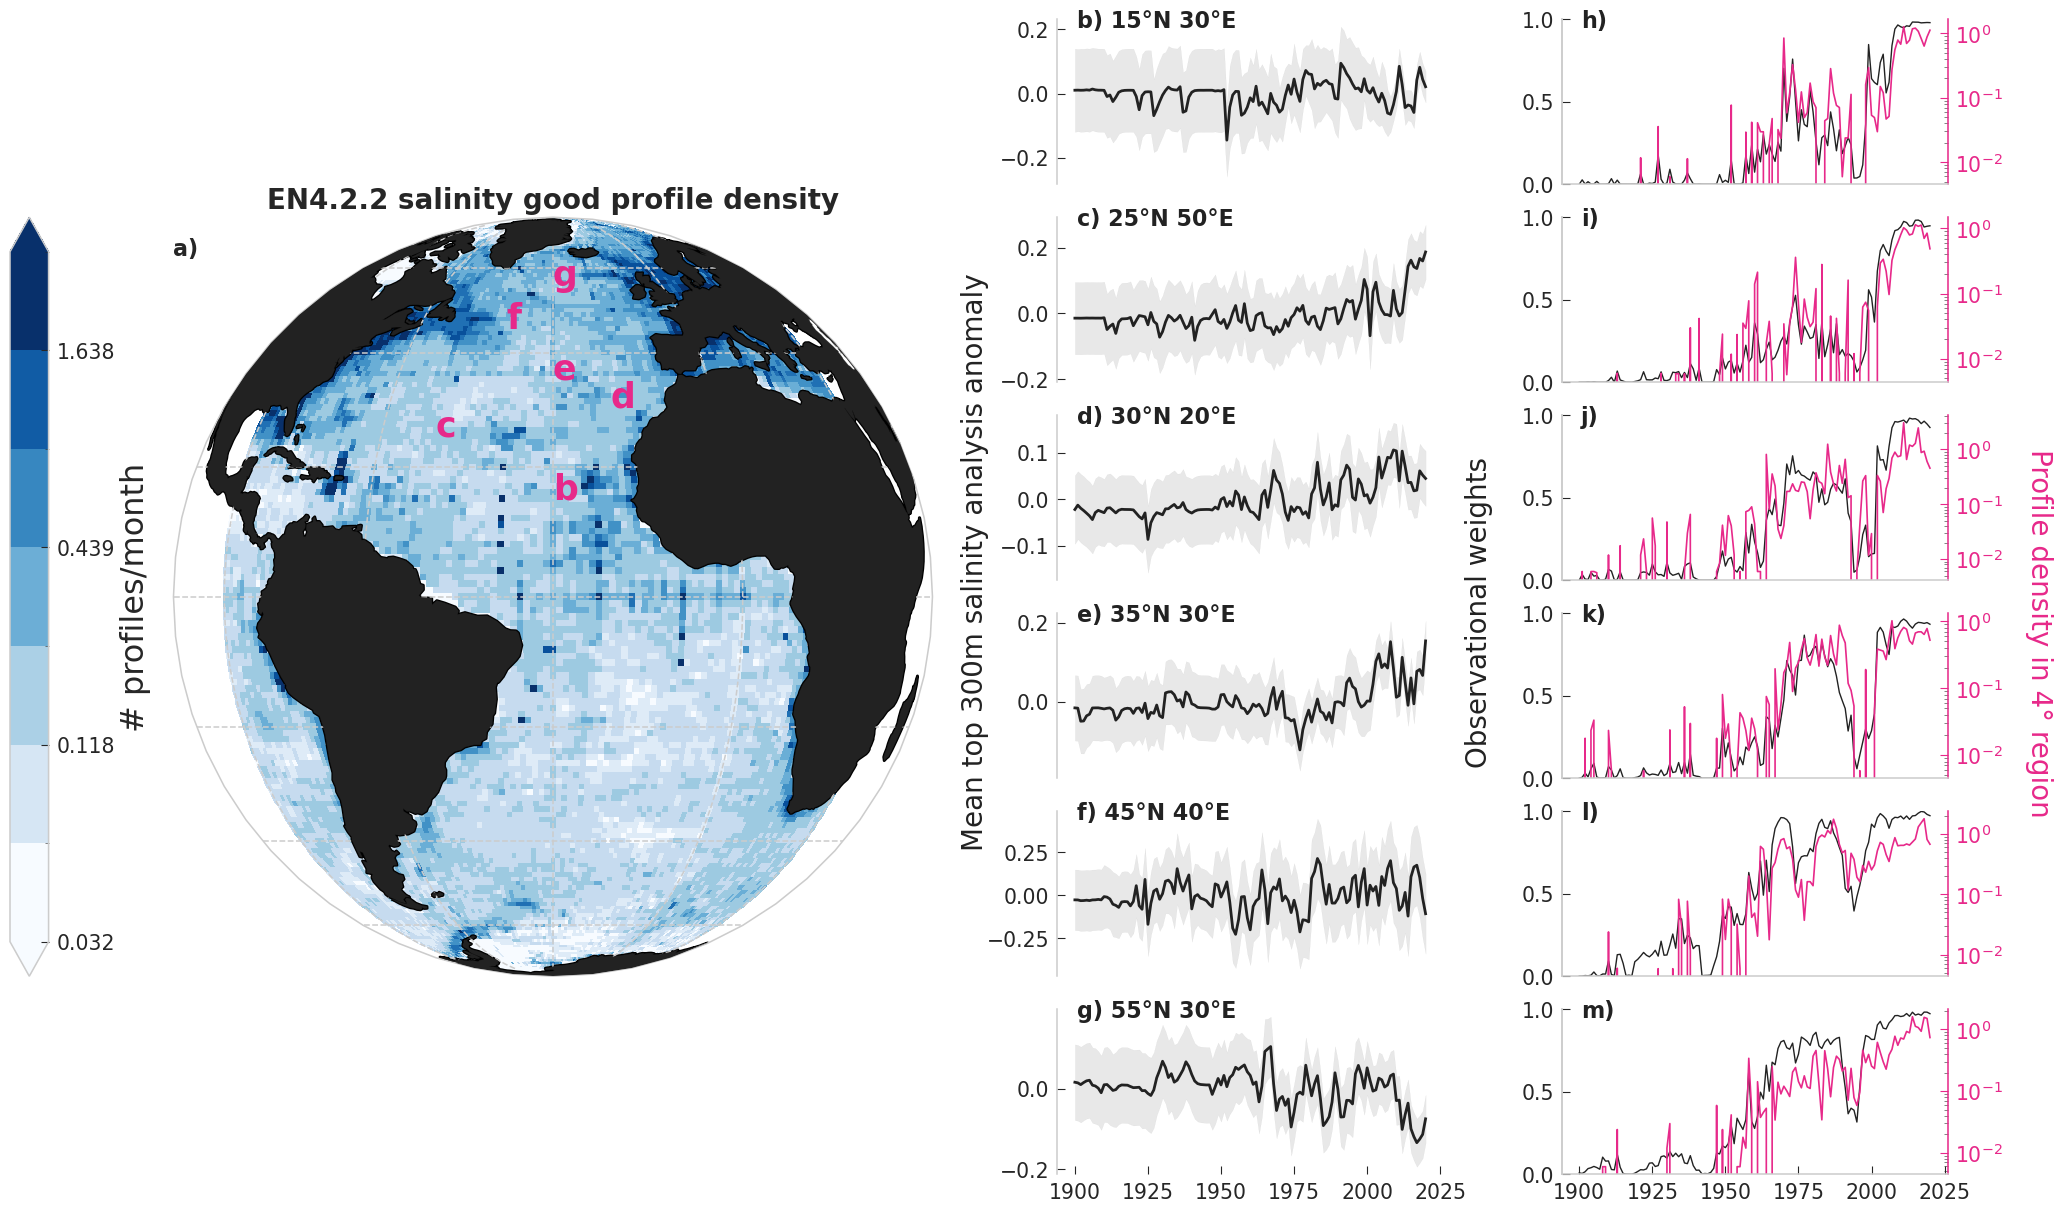

In [22]:
coord_list = [[15,-30],[25,-50],[30,-20],[35,-30],[45,-40],[55,-30]]
color_list = ['C0','C1','C2','C3','C4','C5']


fig = plt.figure(figsize=(25,15))
gs = fig.add_gridspec(nrows=len(coord_list), ncols=4,width_ratios=(0.05,1,0.5,0.5))


ax0 = fig.add_subplot(gs[1:5,1], projection=ccrs.Orthographic(central_longitude=330))
# levelss = np.linspace(0,1,21)
levelss = np.logspace(-1.5,0.5,8)
mean_density.plot(    cmap =  plt.cm.Blues,levels=levelss,ax=ax0,transform = ccrs.PlateCarree(),
                  add_colorbar=False)
#                   cbar_kwargs={"label": "",'orientation':'horizontal'})
ax0.set_global()
ax0.coastlines(linewidth=2)
ax0.gridlines()
ax0.set_title('EN4.2.2 salinity good profile density',fontsize=20,fontweight='bold')
ax0.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax0.text(0,0.95,'a)',transform=ax0.transAxes,fontweight='bold')

cax = fig.add_subplot(gs[1:5,0])
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='# profiles/month',extend='both')

colors = ['C1','C2','C3','C4']
col = 'C3'
for i, coords in enumerate(coord_list):
    lat, lon = coords[0], coords[1]
#     col = colors[i]
#     ax0.scatter(y=lat,x=lon,transform = ccrs.PlateCarree(),s=100,color=col)
    ax0.text(lon,lat,labels[i+1],transform = ccrs.PlateCarree(),color=col,fontweight='bold',fontsize=25)

    x = dmeany.sel(lat=lat,lon=lon)
    dx = dmeany_unc.sel(lat=lat,lon=lon)
    ax = fig.add_subplot(gs[i,2])
    ax.plot(np.arange(1900,2021),(x-x.mean())[:-1],color='k',lw=2)
    ax.fill_between(np.arange(1900,2021),(x-x.mean()-dx)[:-1],(x-x.mean()+dx)[:-1],color='k',alpha=0.1)
#     ax.set_ylabel('Salinity time series',fontsize=15)
    if i==3:
        ax.text(-0.25,-0.4,'Mean top 300m salinity analysis anomaly',transform=ax.transAxes,color='k',fontsize=20,rotation=90)

    # ax.set_xlabel('years',fontsize=15)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if i!=5:
        ax.xaxis.set_ticks_position('none')
        ax.set_xticklabels([])
    ax.text(0.05,0.95,labels[i+1]+') {}°N {}°E'.format(lat,-lon),transform=ax.transAxes,fontweight='bold',color='k')

    wei = dmeany_wei.sel(lat=lat,lon=lon)
    den = densityy.sel(lat=lat,lon=lon)
    dlat = 4
    den_reg = densityy.where((densityy.lat>lat-dlat)&(densityy.lat<lat+dlat)).where((densityy.lon>lon-dlat)&(densityy.lon<lon+dlat)).mean(dim=['lat','lon'])

    ax = fig.add_subplot(gs[i,3])
    ax.plot(np.arange(1900,2021),wei[:-1],color='k',lw=1)
#     ax.set_ylabel('Observational weights',fontsize=15,zorder=20)
#     if i==5:
#         ax.set_xlabel('years',fontsize=15)
    if i==3:
        ax.text(-0.25,0.1,'Observational weights',transform=ax.transAxes,color='k',fontsize=20,rotation=90)

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
#     ax.text(0.05,0.85,labels[i],transform=ax.transAxes,fontweight='bold',color=col)
    if i!=5:
        ax.set_xticklabels([])
        ax.xaxis.set_ticks_position('none')
    ax.set_yticks([0,0.5,1])
    ax.set_ylim(0,1)
    ax.spines.top.set_visible(False)
    ax.text(0.05,0.95,labels[i+7]+')',transform=ax.transAxes,fontweight='bold',color='k')
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.plot(np.arange(1900,2021),den_reg[:-1],color=col)
    if i==3:
        ax.text(1.2,-0.2,'Profile density in 4° region',transform=ax.transAxes,color=col,fontsize=20,rotation=270)
#     ax2.set_ylabel('Profile density\nin 4 km region',fontsize=15)
#     ax2.set_ylim(1e-13,den_reg.max())
    ax2.spines["right"].set_edgecolor(col)
    ax2.yaxis.label.set_color(col)
    ax2.tick_params(axis='y', colors=col)
    ax2.spines.top.set_visible(False)
# fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
fig.savefig('AMOC_uncertainties/plots/nprof.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/nprof.pdf',bbox_inches='tight')
plt.show()

# modification

In [23]:
ar2_surrs = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar2_surrogates/correct_surrogates/to_merge/fit_ar_data2_full_res_dt20_ymean.nc').surrs
ar205 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar2_surrogates/correct_surrogates/fake_ar2_data2_seas_dt20_elim05.nc').lams
dmeany = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_dmean_ymean_at.nc').salinity[:-1]
dmeany_unc = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/uncertainty_dmean_ymean_at.nc').salinity_uncertainty[:-1]

In [24]:
trends05 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_lams_full_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
mu05s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_lams_full_w60_ndt_stats.nc').mu
surr_mu = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_lams_w60_ndt_stats.nc').mu
surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_lams_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)

In [25]:
surr_lams=xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_lams_w60_ndt.nc').lams
lams05=xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_lams_w60_ndt.nc').lams

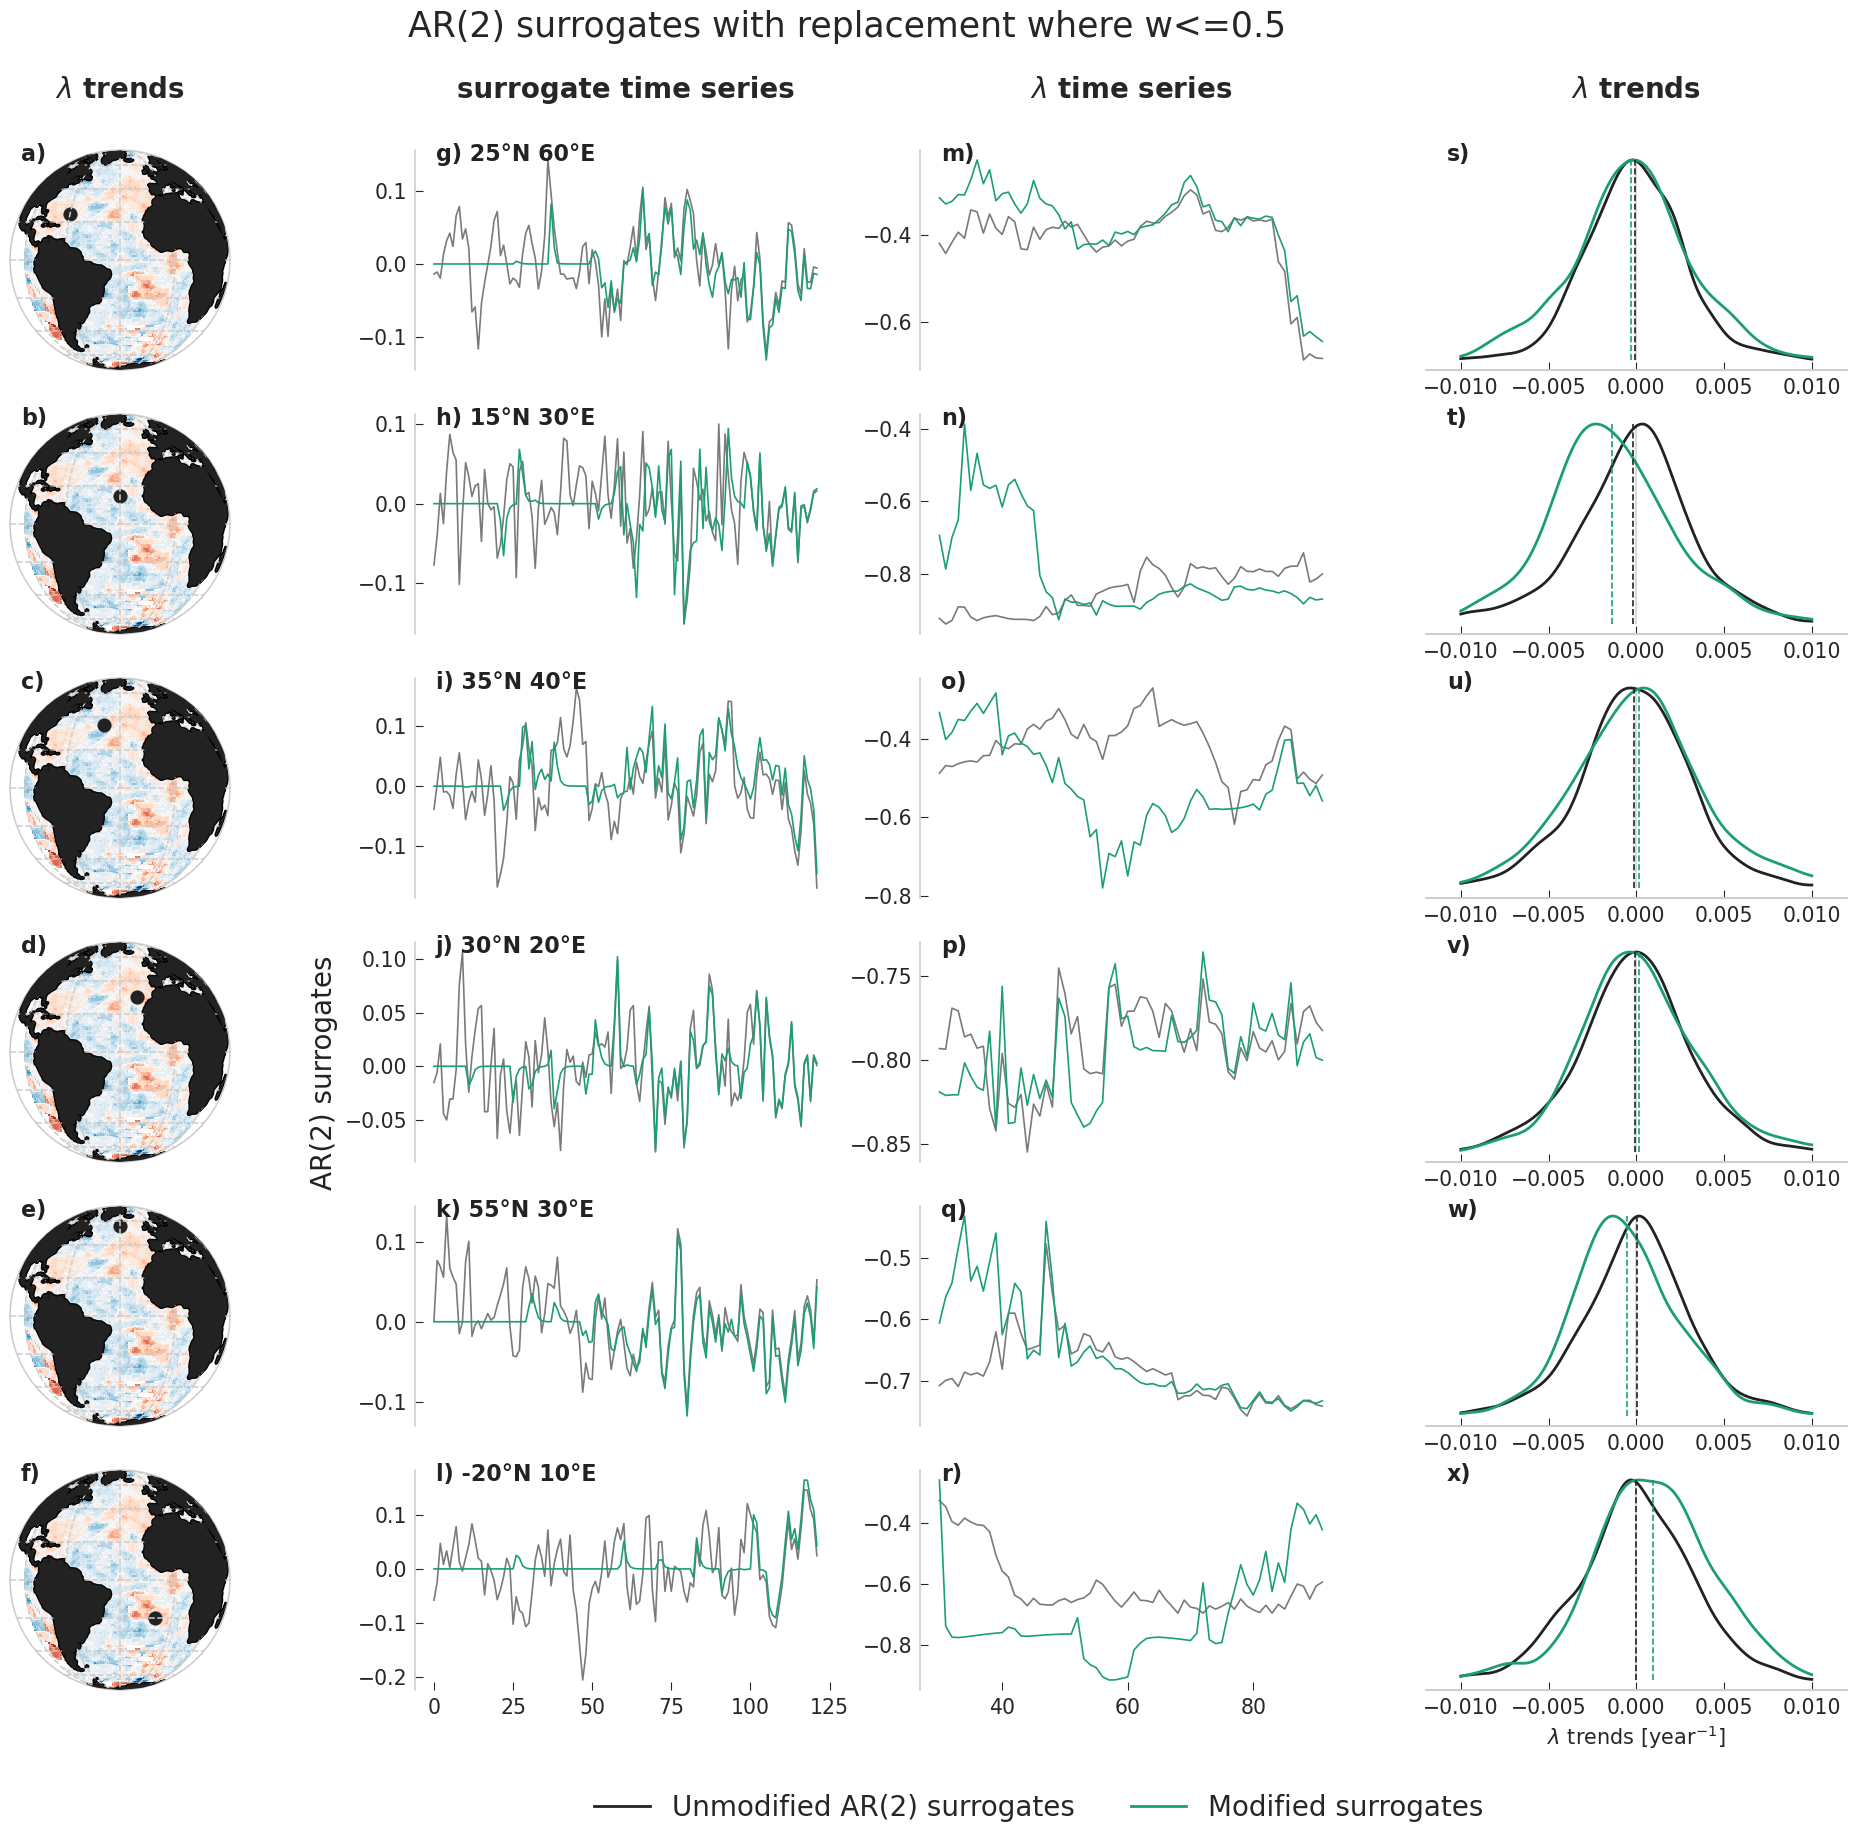

In [26]:
coord_list = [[25,-60],[15,-30],[35,-40],[30,-20],[55,-30],[-20,-10]]
color_list = ['C0','C1','C2','C3','C4','C5']


fig = plt.figure(figsize=(25,20))
gs = fig.add_gridspec(nrows=len(coord_list), ncols=4)


isim = 10
for i, coords in enumerate(coord_list):
    lat, lon = coords[0], coords[1]
    
    ### maps
    ax0 = fig.add_subplot(gs[i,0], projection=ccrs.Orthographic(central_longitude=330))
    levelss = np.linspace(-0.005,0.005,21)
    mu05s.plot(    cmap =  plt.cm.RdBu_r,levels=levelss,ax=ax0,transform = ccrs.PlateCarree(),
                      add_colorbar=False)
    #                   cbar_kwargs={"label": "",'orientation':'horizontal'})
    ax0.set_global()
    ax0.coastlines(linewidth=2)
    ax0.gridlines()
    if i==0:
        ax0.set_title('$\lambda$ trends',fontsize=20,fontweight='bold',y=1.2)
    else:
        ax0.set_title('')
    ax0.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    
#     col = colors[i]
    ax0.scatter(y=lat,x=lon,transform = ccrs.PlateCarree(),s=100,color='k')
    ax0.text(0.05,0.95,labels[i]+')',transform=ax0.transAxes,fontweight='bold',color='k')#########
#     ax0.text(lon,lat,labels[i],transform = ccrs.PlateCarree(),color='k',fontweight='bold')
    
    ## lambda
    ax = fig.add_subplot(gs[i,2])
    slam = surr_lams.sel(lat=lat,lon=lon).isel(surrogates=isim)
    lam05 = lams05.sel(lat=lat,lon=lon).isel(surrogates=isim)
    ax.plot(slam,color='k',alpha=0.6)
    ax.plot(lam05,color='C0',linestyle='-')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if i!=5:
        ax.xaxis.set_ticks_position('none')
        ax.set_xticklabels([])
    if i==0:
        ax.set_title('$\lambda$ time series',fontsize=20,fontweight='bold',y=1.2)
    else:
        ax.set_title('')
    ax.text(0.05,0.95,labels[i+12]+')',transform=ax.transAxes,fontweight='bold',color='k')#################

    ## timeseries
    ax = fig.add_subplot(gs[i,1])
    xs = ar2_surrs.sel(lat=lat,lon=lon).isel(surrogates=isim)
    xs = xs - xs.mean()
    x3 = ar205.sel(lat=lat,lon=lon).isel(surrogates=isim)
    ax.plot(xs.values,color='k',alpha=0.6)
    ax.plot(x3,color='C0',linestyle='-')
    if i==3:
        ax.text(-0.25,-0.1,'AR(2) surrogates',transform=ax.transAxes,color='k',fontsize=20,rotation=90)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if i!=5:
        ax.xaxis.set_ticks_position('none')
        ax.set_xticklabels([])
    ax.text(0.05,0.95,labels[i+6]+') {}°N {}°E'.format(lat,-lon),transform=ax.transAxes,fontweight='bold',color='k')
    if i==0:
        ax.set_title('surrogate time series',fontsize=20,fontweight='bold',y=1.2)
        
    ## histograms
    ax = fig.add_subplot(gs[i,3])
    strnds = surr_trends.sel(lat=lat,lon=lon)
    smu = surr_mu.sel(lat=lat,lon=lon)
    xs = np.linspace(-0.01,0.01,200)
    kde_plot(ax,xs,strnds,col='k',norm=True,lbl='Unmodified AR(2) surrogates')
    ax2 = ax.twinx()
    trnds = trends05.sel(lat=lat,lon=lon)
    mu = mu05s.sel(lat=lat,lon=lon)
    k = kde_plot(ax,xs,trnds,col='C0',norm=True,lbl='Modified surrogates')
    ax.text(0.05,0.95,labels[i+18]+')',transform=ax.transAxes,fontweight='bold',color='k')#################
    if i==0:
        ax.set_title('$\lambda$ trends',fontsize=20,fontweight='bold',y=1.2)   
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('bottom')
    
    ax2.spines.right.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.yaxis.set_ticks_position('none')
    ax2.xaxis.set_ticks_position('bottom')


    if i==5:
        ax.set_xlabel('$\lambda$ trends [year$^{-1}$]',fontsize=15)
        ax.legend(bbox_to_anchor=(-2, -0.65), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)

    ax.set_yticklabels([])
    ax2.set_yticklabels([])
    ax.set_xlim(-0.012,0.012)
#     ax.text(0.01,0.9,labels[idc],transform=ax.transAxes,fontweight='bold')
    ax.vlines(mu,0,1,color='C0',linestyle='--')
    ax.vlines(smu,0,1,color='k',linestyle='--')
    ax.vlines(0,0,1,color='k',alpha=0.2)
#     ax1.text(lon,lat,labels[idc],transform = ccrs.PlateCarree())
    
# fig.tight_layout()
# fig.subplots_adjust(wspace=0.3)
fig.suptitle('AR(2) surrogates with replacement where w<=0.5',fontsize=25,y=0.95)
fig.savefig('AMOC_uncertainties/plots/modification.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/modification.pdf',bbox_inches='tight')

plt.show()

# elimination methods

In [27]:
mu03s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_seas_lams_elim03_w60_runmean_stats.nc').mu
mu01s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_elim01_lams_w60_runmean_stats.nc').mu
mu05s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_elim05_lams_w60_runmean_stats.nc').mu


In [28]:
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_lambdas_w60_runmean.nc').lambdas
true_lam_trend = ds.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

In [29]:
lam_file_names={
    'surrs':'fake_ar2_data2_dt20_surrs_lams',
    'elim03':'fake_ar2_data2_dt20_elim03_lams',
    'elim01':'fake_ar2_data2_dt20_elim01_lams',
    'elim05': 'fake_ar2_data2_dt20_elim05_lams_full',
}

In [30]:
lam_mus = {}
lam_trends = {}
surr_names = ['surrs','elim01','elim03','elim05']

for surr in surr_names:
    print(surr)
    mu = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/{}_w60_ndt_stats.nc'.format(lam_file_names[surr])).mu
    try:
        trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses{}_w60_ndt_trends.nc'.format(lam_file_names[surr])).lams_polyfit_coefficients.sel(degree=1)
    except:
        trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/{}_w60_ndt_trends.nc'.format(lam_file_names[surr])).lams_polyfit_coefficients.sel(degree=1)
    lam_mus[surr]=mu
    lam_trends[surr]=trends
lam_sigs = {}
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_lambdas_w60_runmean.nc').lambdas
true_lam_trend = ds.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
for surr in surr_names:
    print(surr)
    if surr=='surrs':
        lam_sigs[surr]=get_significance(true_lam_trend,lam_trends[surr],edim='surrogates',mdims=['lon','lat'])
    else:
        lam_sigs[surr]=get_significance(true_lam_trend,lam_trends[surr],edim='surrogates')

surrs
elim01
elim03
elim05
surrs
elim01
elim03
elim05


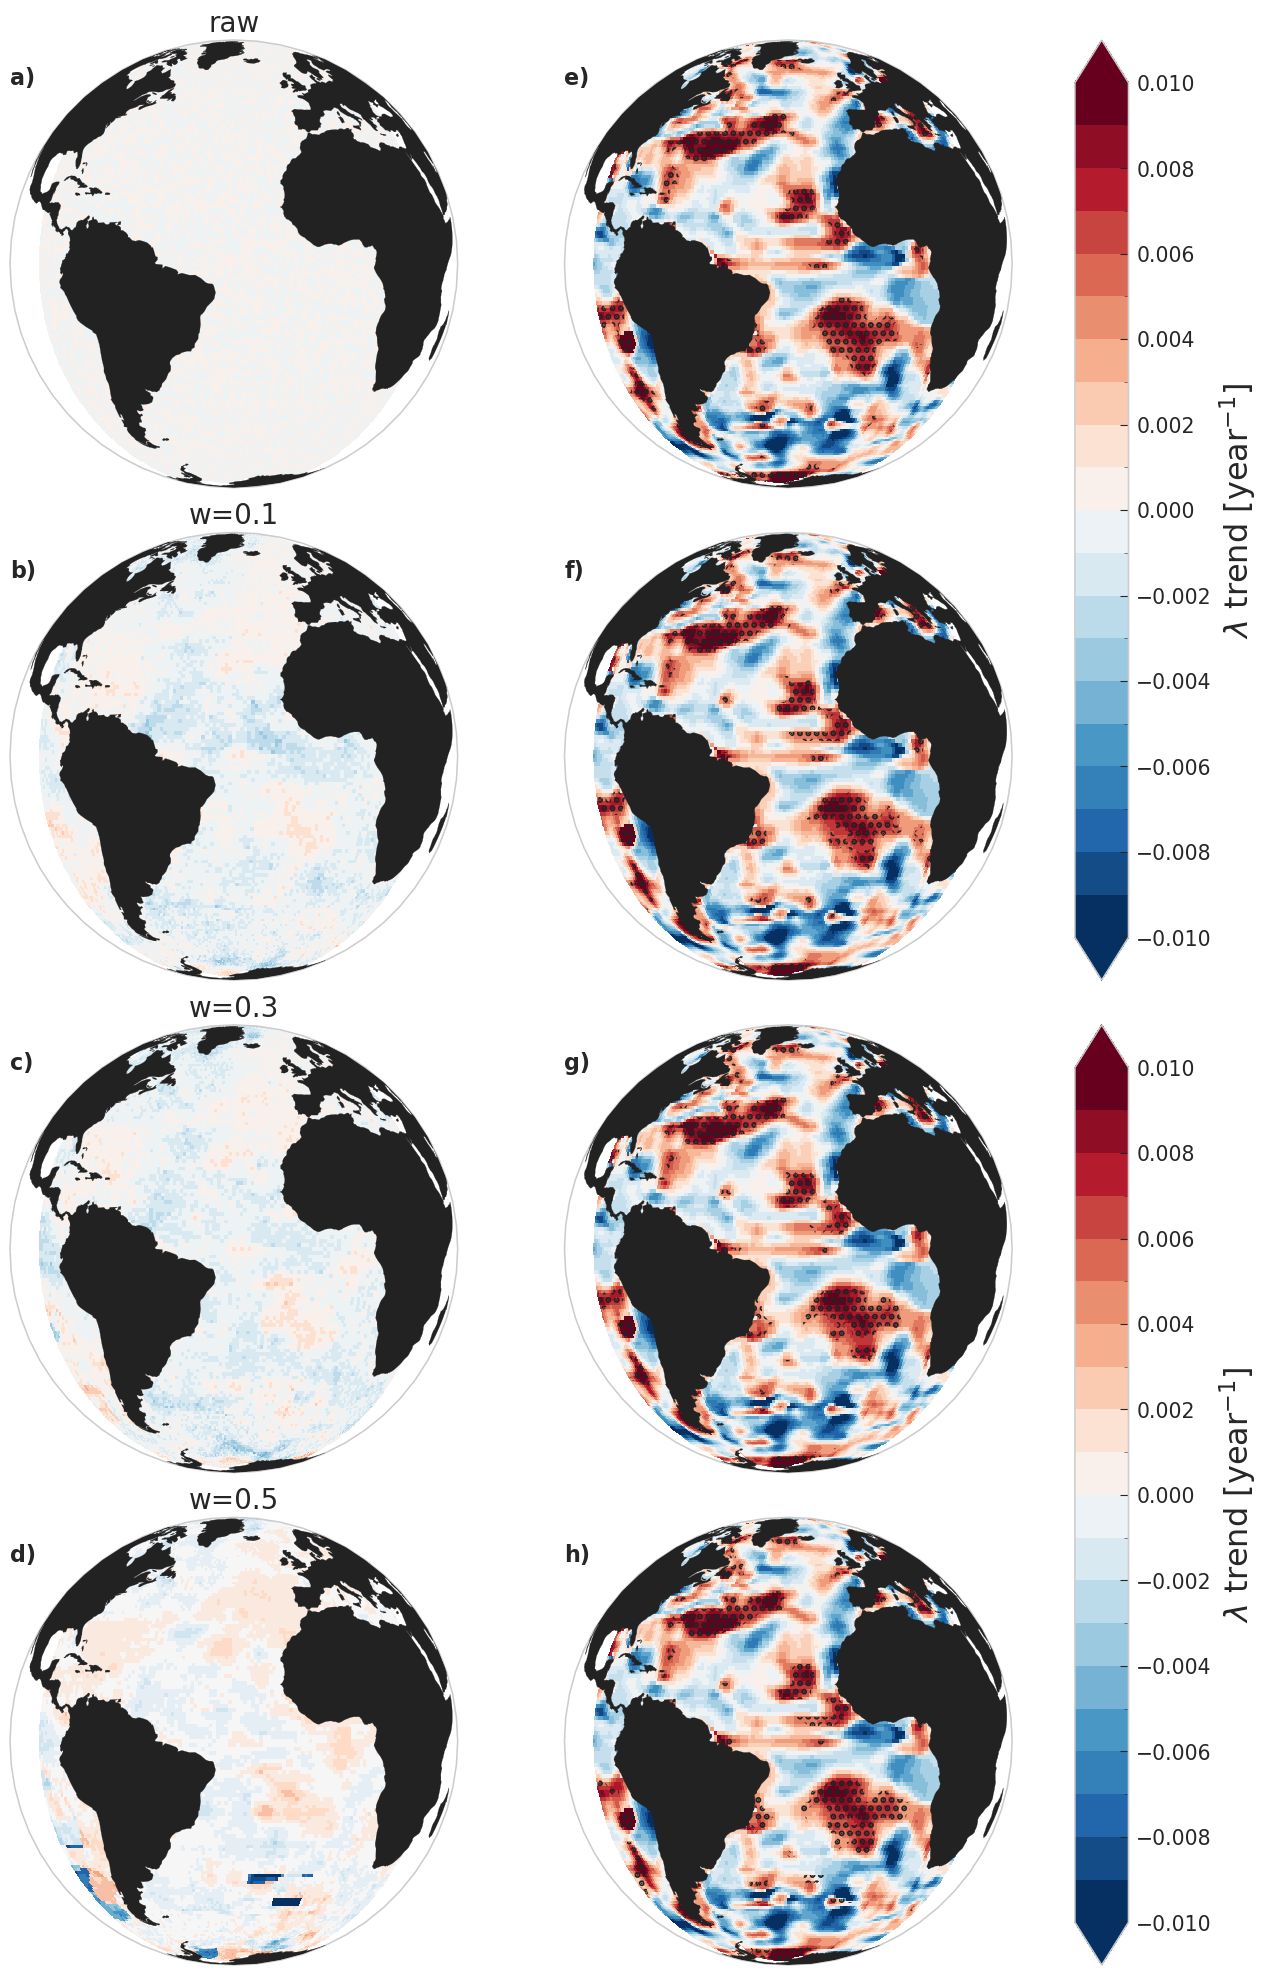

In [31]:
fig = plt.figure(figsize=(15,25))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.01,0.01,21)
mpl.rcParams['hatch.color'] = 'k'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=4, ncols=3,width_ratios=(1,1,0.1))

ttls = ['raw','w=0.1','w=0.3','w=0.5']
for i, surr in enumerate(surr_names):
    ax = fig.add_subplot(gs[i,0], projection=ccrs.Orthographic(central_longitude=330))
    lam_trends[surr].mean(dim='surrogates').plot(
        x = "lon", 
        y = "lat",
        ax = ax,
        levels=levelss,
    cmap =  plt.cm.RdBu_r,
                             add_colorbar=False,
        transform = ccrs.PlateCarree()
    )

    ax.set_global()
    ax.set_title(ttls[i],fontsize=20)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax.text(0,0.9,labels[i]+')',transform=ax.transAxes,fontweight='bold')
    
    ax = fig.add_subplot(gs[i,1], projection=ccrs.Orthographic(central_longitude=330))
    true_lam_trend.plot(
        x = "lon", 
        y = "lat",
        ax = ax,
        levels=levelss,
    cmap =  plt.cm.RdBu_r,
                             add_colorbar=False,
        transform = ccrs.PlateCarree()
    )

    lam_sigs[surr].plot.contourf(x='lon',y='lat',levels = [-100,100],hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
    ax.set_global()
    ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax.text(0,0.9,labels[i+4]+')',transform=ax.transAxes,fontweight='bold')
    ax.set_title('')

cax = fig.add_subplot(gs[:2,2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='$\lambda$ trend [year$^{-1}$]',extend='both')
cax = fig.add_subplot(gs[2:,2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='$\lambda$ trend [year$^{-1}$]',extend='both')

fig.subplots_adjust(hspace=0.1,wspace=0.05)
# fig.suptitle('Modified AR(2) surrogates',fontsize=25,y=0.91)
fig.savefig('AMOC_uncertainties/plots/elim_options.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/elim_options.pdf',bbox_inches='tight')
plt.show()

# years above weight bound

In [32]:
dmeany_wei = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/weights_dmean_ymean_at.nc').salinity_observation_weights.squeeze()[:-1]
y005 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.05)))
y05 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.5)))
y03 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.3)))


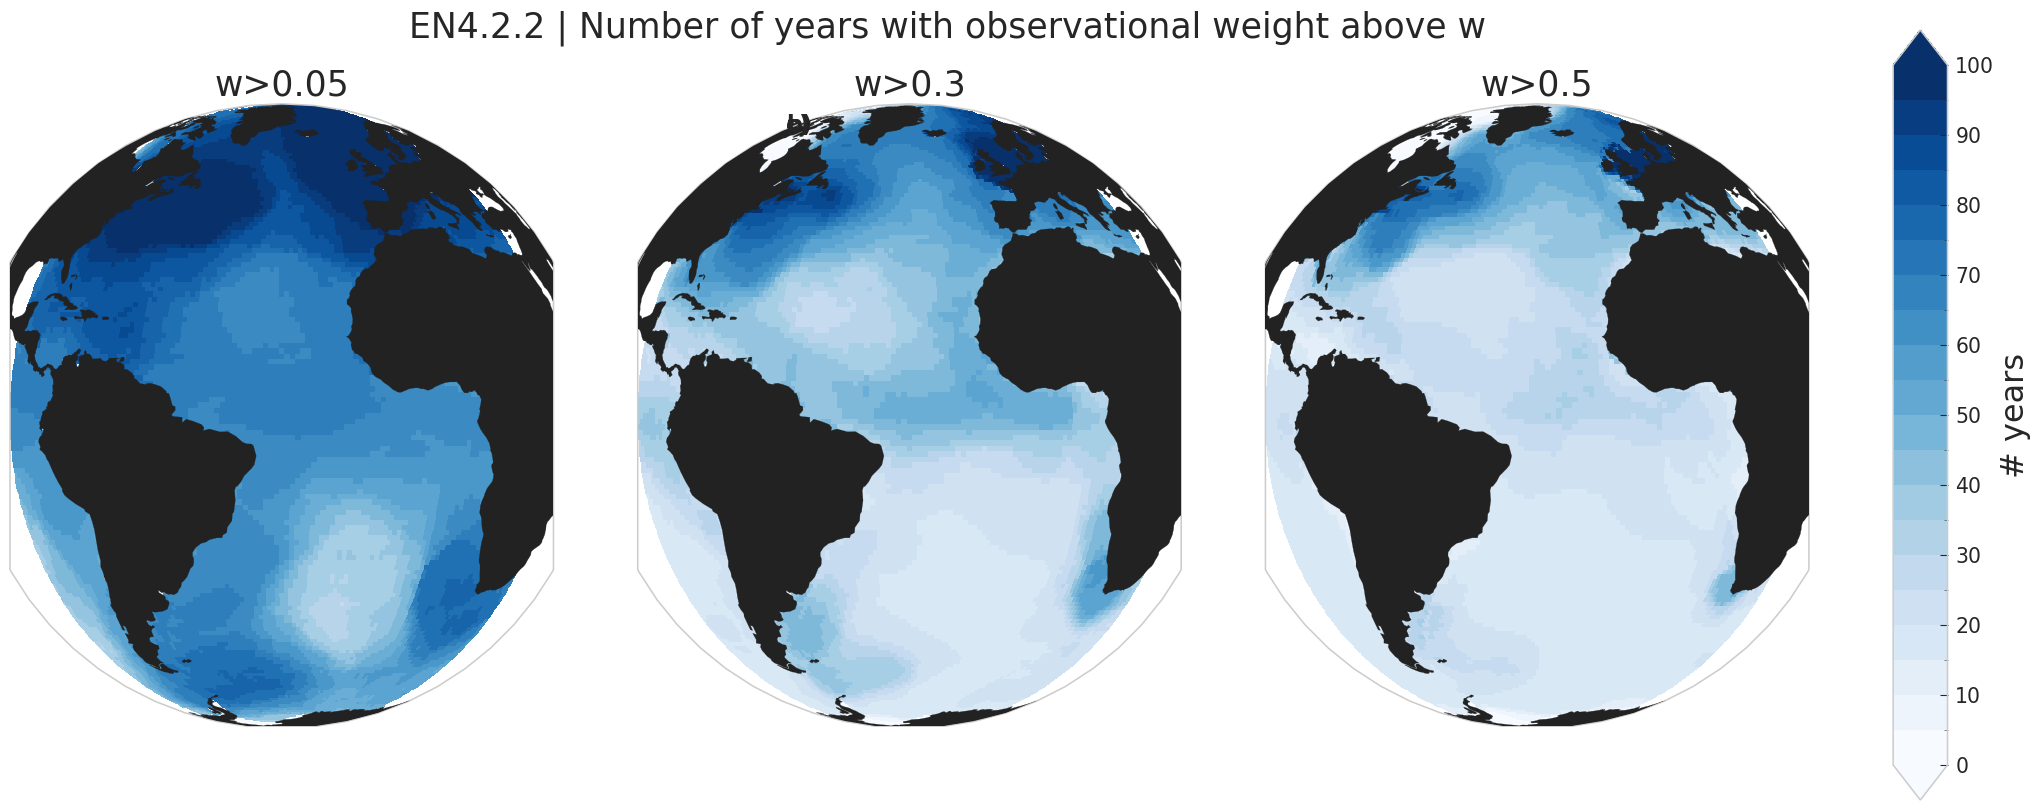

In [33]:
levelss = np.linspace(0,100,21)

mpl.rcParams['hatch.color'] = 'k'
mpl.rcParams['hatch.linewidth'] = 3
fig = plt.figure(figsize=(25,10))
gs = fig.add_gridspec(nrows=1, ncols=4,width_ratios=(1,1,1,0.1))

ax1 = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
ax3 = fig.add_subplot(gs[0,2], projection=ccrs.Orthographic(central_longitude=330))

y005.sum(dim='time').plot(
        x = "lon", 
        y = "lat",
        ax = ax1,
        levels=levelss,
    cmap =  plt.cm.Blues,
    add_colorbar=False,
#         cbar_kwargs={"label": "# years",'orientation':'vertical'},
        transform = ccrs.PlateCarree())

y03.sum(dim='time').plot(
        x = "lon", 
        y = "lat",
        ax = ax2,
        levels=levelss,
    cmap =  plt.cm.Blues,
    add_colorbar=False,
#         cbar_kwargs={"label": "# years",'orientation':'vertical'},
        transform = ccrs.PlateCarree())

y05.sum(dim='time').plot(
        x = "lon", 
        y = "lat",
        ax = ax3,
        levels=levelss,
    cmap =  plt.cm.Blues,
    add_colorbar=False,
#         cbar_kwargs={"label": "# years",'orientation':'vertical'},
        transform = ccrs.PlateCarree())

cax = fig.add_subplot(gs[0,3])
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='# years',extend='both')
ax1.set_title('w>0.05',fontsize=25)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax1.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')
ax2.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')
ax3.text(0,0.9,'c)',transform=ax.transAxes,fontweight='bold')
ax2.set_title('w>0.3',fontsize=25)
ax2.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax3.set_title('w>0.5',fontsize=25)
ax3.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
fig.suptitle('EN4.2.2 | Number of years with observational weight above w',fontsize=25,y=0.9)
fig.savefig('AMOC_uncertainties/plots/w_years.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/w_years.pdf',bbox_inches='tight')
plt.show()

# autocorrelation

In [34]:
from scipy.stats import gaussian_kde

def kde_plot(ax,xs,data,col='C0',lbl='',linestyle='-',norm=False):
    data = data[~np.isnan(data)]
    if data.sum()==0:
        ax.plot(xs,np.full_like(xs,0))
    else:
        density = gaussian_kde(data)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ys = density(xs)
        if norm:
            ax.plot(xs,ys/ys.max(),color=col,label=lbl,lw=2,linestyle=linestyle)
        else:
            ax.plot(xs,ys,color=col,label=lbl,lw=2,linestyle=linestyle)

In [35]:
ya_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/dt20_yar1_last40.nc').ar1
ya_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/dt20_yar1_first40.nc').ar1
ma_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/dt20_mar1_last40.nc').ar1
ma_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/dt20_mar1_first40.nc').ar1


In [36]:
fake_ma_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_mar1_last40.nc').ar1
fake_ma_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_mar1_first40.nc').ar1

fake_ya_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_last40.nc').ar1
fake_ya_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_first40.nc').ar1

fake_elim01_ya_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_elim01_last40.nc').ar1
fake_elim01_ya_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_elim01_first40.nc').ar1

fake_elim03_ya_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_elim03_last40.nc').ar1
fake_elim03_ya_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_elim03_first40.nc').ar1

fake_elim05_ya_l40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_elim05_last40.nc').ar1
fake_elim05_ya_f40 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/ar1/full_fake2_dt20_yar1_elim05_first40.nc').ar1


In [37]:
# fig = plt.figure(figsize = (15,8))

# ax = fig.add_subplot(221)
# xs = np.linspace(0,1,200)
# kde_plot(ax,xs,ma_f40.values.ravel(),col='k',norm=True)
# kde_plot(ax,xs, fake_ma_f40.values.ravel(),col='k',norm=True,linestyle='--')
# ax.set_title('First 40 years - monthly')
# ax.set_xlabel('AR(1)',fontsize=15)

# ax = fig.add_subplot(222)
# xs = np.linspace(0,1,200)
# kde_plot(ax,xs,ya_f40.values.ravel(),col='k',norm=True)
# kde_plot(ax,xs, fake_elim01_ya_f40.values.ravel(),col='C0',norm=True)
# kde_plot(ax,xs, fake_elim03_ya_f40.values.ravel(),col='C1',norm=True)
# kde_plot(ax,xs, fake_elim05_ya_f40.values.ravel(),col='C2',norm=True)
# kde_plot(ax,xs, fake_ya_f40.values.ravel(),col='k',norm=True,linestyle='--')
# ax.set_title('First 40 years - yearly')
# ax.set_xlabel('AR(1)',fontsize=15)

# ax = fig.add_subplot(223)
# xs = np.linspace(0,1,200)
# kde_plot(ax,xs,ma_l40.values.ravel(),col='k',norm=True)
# kde_plot(ax,xs, fake_ma_l40.values.ravel(),col='k',norm=True,linestyle='--')
# ax.set_title('Last 40 years - monthly')
# ax.set_xlabel('AR(1)',fontsize=15)

# ax = fig.add_subplot(224)
# xs = np.linspace(0,1,200)
# kde_plot(ax,xs,ya_l40.values.ravel(),col='k',norm=True,lbl='Analysis')
# kde_plot(ax,xs, fake_ya_l40.values.ravel(),col='k',norm=True,linestyle='--',lbl='Raw AR(2) surrogates')
# kde_plot(ax,xs, fake_elim03_ya_l40.values.ravel(),col='C0',norm=True,lbl='elim01')
# kde_plot(ax,xs, fake_elim03_ya_l40.values.ravel(),col='C1',norm=True,lbl='elim03')
# kde_plot(ax,xs, fake_elim03_ya_l40.values.ravel(),col='C2',norm=True,lbl='eim05')
# ax.legend(bbox_to_anchor=(-1.3, -0.4), loc='lower left', ncol=5,borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
# ax.set_title('Last 40 years - yearly')
# ax.set_xlabel('AR(1)',fontsize=15)
# fig.subplots_adjust(hspace=0.3)
# fig.suptitle('Autocorrelation of all gridcells',fontsize=25)
# fig.savefig('AMOC_uncertainties/plots/ar1_kdes.png',bbox_inches='tight')
# fig.savefig('AMOC_uncertainties/plots/ar1_kdes.pdf',bbox_inches='tight')
# plt.show()

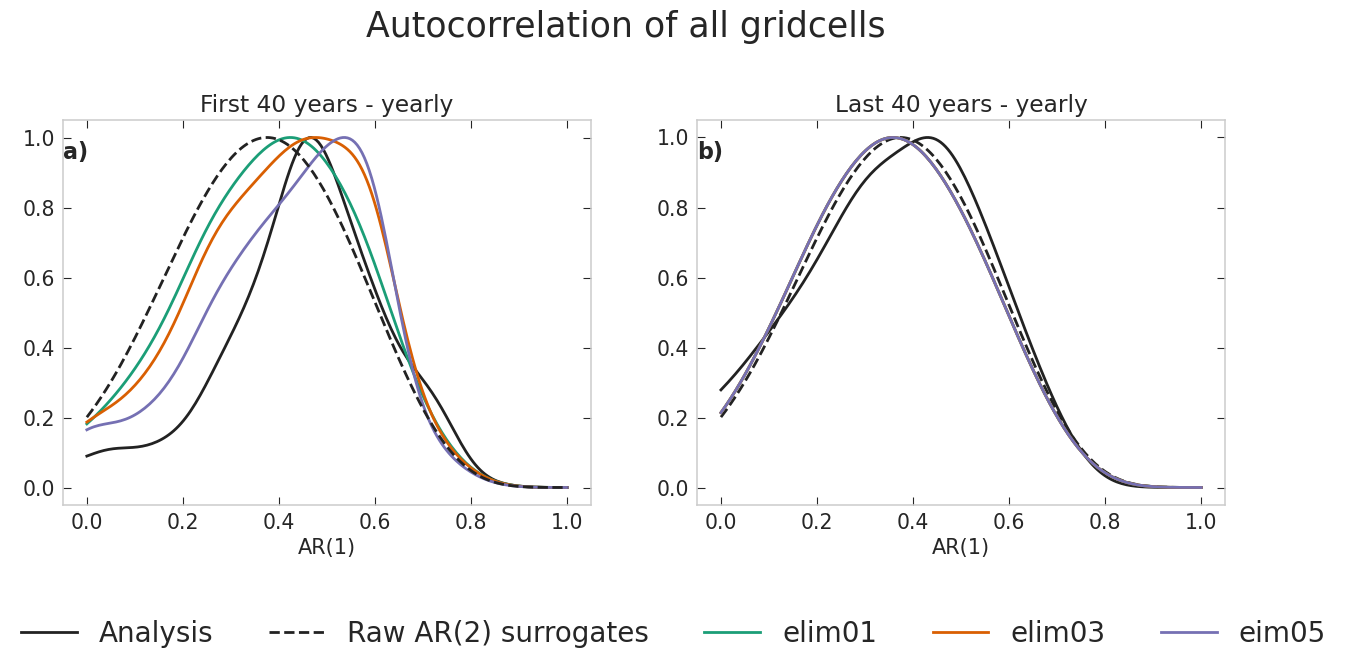

In [38]:
fig = plt.figure(figsize = (15,5))


ax = fig.add_subplot(121)
xs = np.linspace(0,1,200)
kde_plot(ax,xs,ya_f40.values.ravel(),col='k',norm=True)
kde_plot(ax,xs, fake_elim01_ya_f40.values.ravel(),col='C0',norm=True)
kde_plot(ax,xs, fake_elim03_ya_f40.values.ravel(),col='C1',norm=True)
kde_plot(ax,xs, fake_elim05_ya_f40.values.ravel(),col='C2',norm=True)
kde_plot(ax,xs, fake_ya_f40.values.ravel(),col='k',norm=True,linestyle='--')
ax.set_title('First 40 years - yearly')
ax.set_xlabel('AR(1)',fontsize=15)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(122)
xs = np.linspace(0,1,200)
kde_plot(ax,xs,ya_l40.values.ravel(),col='k',norm=True,lbl='Analysis')
kde_plot(ax,xs, fake_ya_l40.values.ravel(),col='k',norm=True,linestyle='--',lbl='Raw AR(2) surrogates')
kde_plot(ax,xs, fake_elim03_ya_l40.values.ravel(),col='C0',norm=True,lbl='elim01')
kde_plot(ax,xs, fake_elim03_ya_l40.values.ravel(),col='C1',norm=True,lbl='elim03')
kde_plot(ax,xs, fake_elim03_ya_l40.values.ravel(),col='C2',norm=True,lbl='eim05')
ax.legend(bbox_to_anchor=(-1.3, -0.4), loc='lower left', ncol=5,borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_title('Last 40 years - yearly')
ax.set_xlabel('AR(1)',fontsize=15)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Autocorrelation of all gridcells',fontsize=25,y=1.1)
fig.savefig('AMOC_uncertainties/plots/ar1_kdes.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/ar1_kdes.pdf',bbox_inches='tight')
plt.show()

# Autocorrelation and variance

## HadCRUT ensemble map

In [39]:
Clams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_lambdas.nc').lams
Car1s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_ar1s.nc').lams
Cstds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_stds.nc').lams
Cmean_trends = Clams.polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)
Car1s_mean_trends = Car1s.polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)
Cstd_mean_trends = Cstds.polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)


In [40]:
Ear1s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/ERSSTv5_ar1s_w60_rmean.nc').sst
Estds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/ERSSTv5_stds_w60_rmean.nc').sst
Ear1s['time']=np.arange(1854,2023)
Estds['time']=np.arange(1854,2023)
Ear1s_mean_trends = Ear1s.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
Estd_mean_trends = Estds.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)


In [41]:
ar1_Eens_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_ar1s_w60_rmean_trends.nc').polyfit_coefficients.sel(degree=1)
ar1_Eens_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_ar1s_w60_rmean_stats.nc').mu
ar1_Eens_sigmas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_ar1s_w60_rmean_stats.nc').sigma

std_Eens_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_stds_w60_rmean_trends.nc').polyfit_coefficients.sel(degree=1)
std_Eens_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_stds_w60_rmean_stats.nc').mu
std_Eens_sigmas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/EWS/sst2d.ano.1854.2017.ensemble_full_at2_stds_w60_rmean_stats.nc').sigma


In [42]:
ar1_ens_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_ar1s2_w60_runmean_stats.nc').mu
ar1_ens_sigmas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_ar1s2_w60_runmean_stats.nc').sigma
ar1_ens_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_ar1s2_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)

std_ens_mus = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_stds_w60_runmean_stats.nc').mu
std_ens_sigmas = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_stds_w60_runmean_stats.nc').sigma
std_ens_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_stds_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)

### ar1

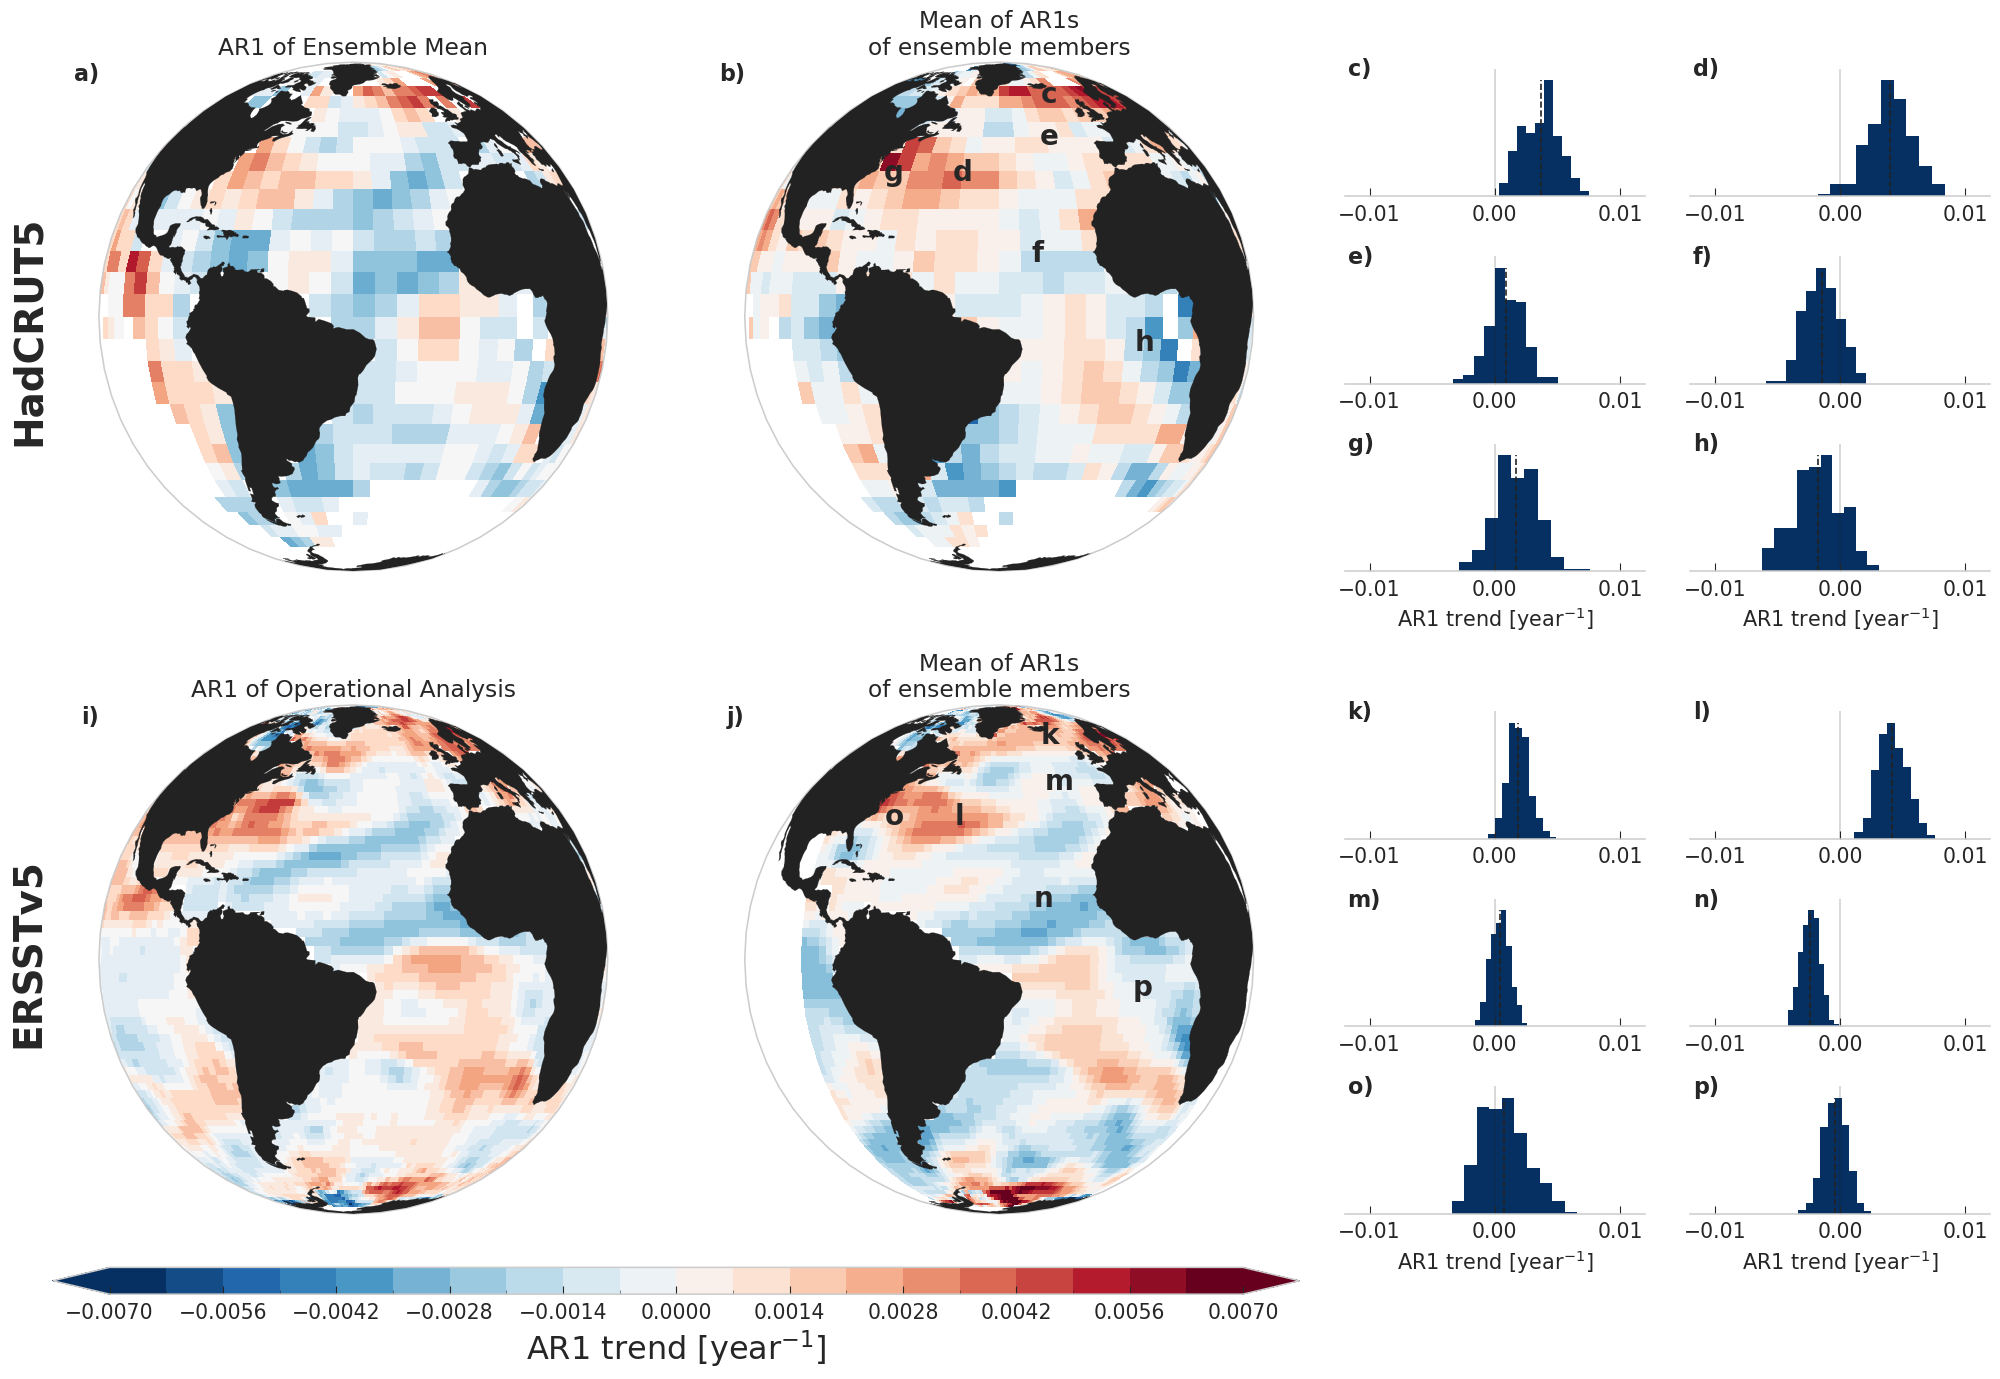

In [43]:
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)

lbls = ['AR1 of Ensemble Mean','Mean of AR1s\nof ensemble members']
levelss = np.linspace(-0.007,0.007,21)
fig = plt.figure(figsize=(25,16))
lblsize =18
mpl.rcParams['hatch.color'] = 'green'
gs = fig.add_gridspec(nrows=8, ncols=4,width_ratios=(1,1,0.5,0.5),height_ratios=(1,1,1,0.2,1,1,1,0.2))

### HadCRUT

datas = [Car1s_mean_trends,ar1_ens_mus]
for i, data in enumerate(datas):
    ax1 = fig.add_subplot(gs[:3,i], projection=ccrs.Orthographic(central_longitude=320))
    data.plot(
            x = "longitude", 
            y = "latitude",
            ax = ax1,
    #     colors = colorss,
        levels = levelss,
            cmap=plt.cm.RdBu_r,
        add_colorbar=False,
#         cbar_kwargs={"label": "AR1 trend [year$^{-1}$]"},
            transform = ccrs.PlateCarree()
        )
    if i==0:
#         esignificant.plot(levels=[-100,100],colors=['C0','C0'],add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
#         shifted_esig.pv.plot.contourf(levels = [-100,100],hatches=['|||'],corner_mask=False,colors='none',add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
        ax1.text(-0.1,0.7,'HadCRUT5',transform=ax1.transAxes,fontweight='bold', va='top', fontsize=28, ha='right',rotation=90)

    ax1.set_title(lbls[i])
    ax1.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax1.text(0,1,labels[i]+')',transform=ax1.transAxes,fontweight='bold', va='top', ha='right')
    ax1.set_global()
lbls = ['AR1 of Operational Analysis','Mean of AR1s\nof ensemble members']  
datas = [Ear1s_mean_trends,ar1_Eens_mus]
for i, data in enumerate(datas):
    ax2 = fig.add_subplot(gs[4:7,i], projection=ccrs.Orthographic(central_longitude=320))
    data.plot(
            x = "lon", 
            y = "lat",
            ax = ax2,
    #     colors = colorss,
        levels = levelss,
            cmap=plt.cm.RdBu_r,
        add_colorbar=False,
#         cbar_kwargs={"label": "AR1 trend [year$^{-1}$]"},
            transform = ccrs.PlateCarree()
        )
    if i==0:
#         esignificant.plot(levels=[-100,100],colors=['C0','C0'],add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
#         Eshifted_esig.pv.plot.contourf(levels = [-100,100],hatches=['|||'],
#                                        corner_mask=False,colors='none',add_colorbar=False,
#                                        ax=ax2,transform = ccrs.PlateCarree())
        ax2.text(-0.1,0.7,'ERSSTv5',transform=ax2.transAxes,fontweight='bold', va='top', fontsize=28, ha='right',rotation=90)
    ax2.set_title(lbls[i])
    ax2.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax2.text(0,1,labels[i+8]+')',transform=ax2.transAxes,fontweight='bold', va='top', ha='right')
    ax2.set_global()    
    
coordss = [[[57.5,-22.5],[32.5,-52.5]],[[42.5,-27.5],[12.5,-32.5]],[[32.5,-72.5],[-7.5,-7.5]]]
idc = -1
for i, coords in enumerate(coordss):
    for j, coord in enumerate(coords):
        idc = idc+1
        ax = fig.add_subplot(gs[i,j+2])
        lat, lon = coord[0], coord[1]
        trnds = ar1_ens_trends.sel(latitude=lat,longitude=lon)
        mu = ar1_ens_mus.sel(latitude=lat,longitude=lon)
        h = ax.hist(trnds,bins=10,color=cmap(norm(mu.values)),density=True)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')

        if i==2:
            ax.set_xlabel('AR1 trend [year$^{-1}$]',fontsize=15)
        ax.set_yticklabels([])
        ax.set_xlim(-0.012,0.012)
        ax.text(0.01,0.9,labels[idc+2]+')',transform=ax.transAxes,fontweight='bold')
        ax.vlines(mu,0,h[0].max(),color='k',linestyle='--')
        ax.vlines(0,0,h[0].max()*1.1,color='k',alpha=0.2)
        ax1.text(lon,lat,labels[idc+2],transform = ccrs.PlateCarree(),fontweight='bold',fontsize=20)

coordss = [[[58,-22],[32,-52]],[[42,-26],[12,-32]],[[32,-72],[-8,-8]]]
idc = -1
for i, coords in enumerate(coordss):
    for j, coord in enumerate(coords):
        idc = idc+1
        ax = fig.add_subplot(gs[i+4,j+2])
        lat, lon = coord[0], coord[1]
        trnds = ar1_Eens_trends.sel(lat=lat,lon=lon)
        mu = ar1_Eens_mus.sel(lat=lat,lon=lon)
        h = ax.hist(trnds,bins=10,color=cmap(norm(mu.values)),density=True)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')

        if i==2:
            ax.set_xlabel('AR1 trend [year$^{-1}$]',fontsize=15)
        ax.set_yticklabels([])
        ax.set_xlim(-0.012,0.012)
        ax.text(0.01,0.9,labels[idc+2+8]+')',transform=ax.transAxes,fontweight='bold')
        ax.vlines(mu,0,h[0].max(),color='k',linestyle='--')
        ax.vlines(0,0,h[0].max()*1.1,color='k',alpha=0.2)
        ax2.text(lon,lat,labels[idc+2+8],transform = ccrs.PlateCarree(),fontweight='bold',fontsize=20)

        
cax = fig.add_subplot(gs[7,:2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='horizontal',label='AR1 trend [year$^{-1}$]',extend='both')    
            
        
fig.subplots_adjust(hspace=0.5,wspace=0.1)
fig.savefig('AMOC_uncertainties/plots/ar1_ensemble_maps.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/ar1_ensemble_maps.pdf',bbox_inches='tight')

plt.show()

### std

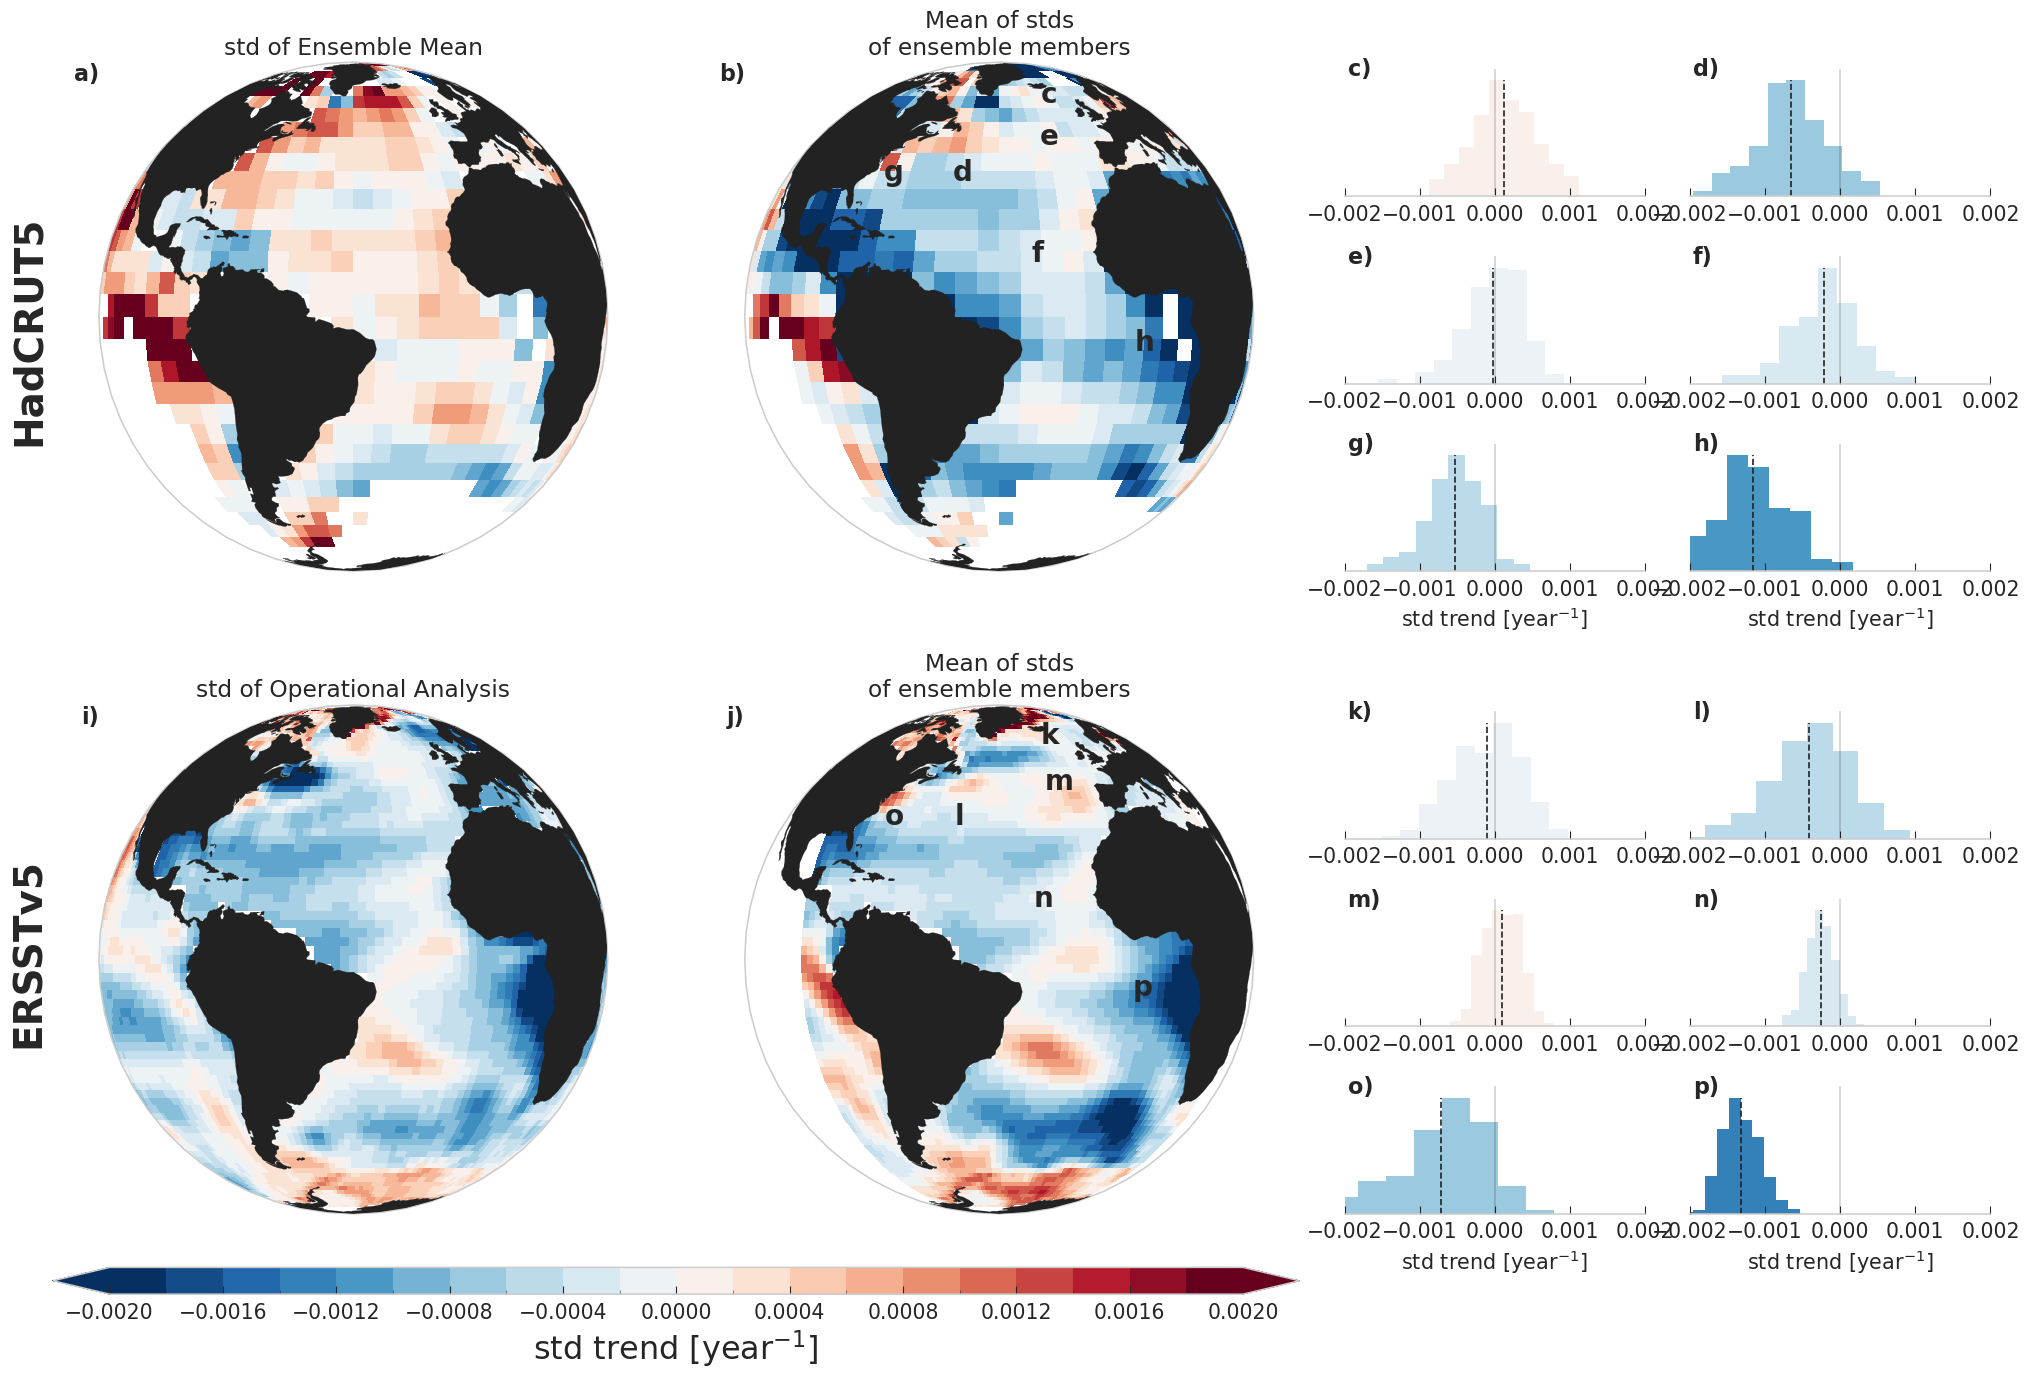

In [44]:
levelss = np.linspace(-0.002,0.002,21)

cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)

lbls = ['std of Ensemble Mean','Mean of stds\nof ensemble members']
levelss = np.linspace(-0.002,0.002,21)
fig = plt.figure(figsize=(25,16))
lblsize =18
mpl.rcParams['hatch.color'] = 'green'
gs = fig.add_gridspec(nrows=8, ncols=4,width_ratios=(1,1,0.5,0.5),height_ratios=(1,1,1,0.2,1,1,1,0.2))

### HadCRUT

datas = [Cstd_mean_trends,std_ens_mus]
for i, data in enumerate(datas):
    ax1 = fig.add_subplot(gs[:3,i], projection=ccrs.Orthographic(central_longitude=320))
    data.plot(
            x = "longitude", 
            y = "latitude",
            ax = ax1,
    #     colors = colorss,
        levels = levelss,
            cmap=plt.cm.RdBu_r,
        add_colorbar=False,
#         cbar_kwargs={"label": "std trend [year$^{-1}$]"},
            transform = ccrs.PlateCarree()
        )
    if i==0:
#         esignificant.plot(levels=[-100,100],colors=['C0','C0'],add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
#         shifted_esig.pv.plot.contourf(levels = [-100,100],hatches=['|||'],corner_mask=False,colors='none',add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
        ax1.text(-0.1,0.7,'HadCRUT5',transform=ax1.transAxes,fontweight='bold', va='top', fontsize=28, ha='right',rotation=90)

    ax1.set_title(lbls[i])
    ax1.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax1.text(0,1,labels[i]+')',transform=ax1.transAxes,fontweight='bold', va='top', ha='right')
    ax1.set_global()
lbls = ['std of Operational Analysis','Mean of stds\nof ensemble members']
    
datas = [Estd_mean_trends,std_Eens_mus]
for i, data in enumerate(datas):
    ax2 = fig.add_subplot(gs[4:7,i], projection=ccrs.Orthographic(central_longitude=320))
    data.plot(
            x = "lon", 
            y = "lat",
            ax = ax2,
    #     colors = colorss,
        levels = levelss,
            cmap=plt.cm.RdBu_r,
        add_colorbar=False,
#         cbar_kwargs={"label": "std trend [year$^{-1}$]"},
            transform = ccrs.PlateCarree()
        )
    if i==0:
#         esignificant.plot(levels=[-100,100],colors=['C0','C0'],add_colorbar=False,ax=ax1,transform = ccrs.PlateCarree())
#         Eshifted_esig.pv.plot.contourf(levels = [-100,100],hatches=['|||'],
#                                        corner_mask=False,colors='none',add_colorbar=False,
#                                        ax=ax2,transform = ccrs.PlateCarree())
        ax2.text(-0.1,0.7,'ERSSTv5',transform=ax2.transAxes,fontweight='bold', va='top', fontsize=28, ha='right',rotation=90)
    ax2.set_title(lbls[i])
    ax2.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
    ax2.text(0,1,labels[i+8]+')',transform=ax2.transAxes,fontweight='bold', va='top', ha='right')
    ax2.set_global()    
    
coordss = [[[57.5,-22.5],[32.5,-52.5]],[[42.5,-27.5],[12.5,-32.5]],[[32.5,-72.5],[-7.5,-7.5]]]
idc = -1
for i, coords in enumerate(coordss):
    for j, coord in enumerate(coords):
        idc = idc+1
        ax = fig.add_subplot(gs[i,j+2])
        lat, lon = coord[0], coord[1]
        trnds = std_ens_trends.sel(latitude=lat,longitude=lon)
        mu = std_ens_mus.sel(latitude=lat,longitude=lon)
        h = ax.hist(trnds,bins=10,color=cmap(norm(mu)),density=True)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')

        if i==2:
            ax.set_xlabel('std trend [year$^{-1}$]',fontsize=15)
        ax.set_yticklabels([])
        ax.set_xlim(-0.002,0.002)
        ax.text(0.01,0.9,labels[idc+2]+')',transform=ax.transAxes,fontweight='bold')
        ax.vlines(mu,0,h[0].max(),color='k',linestyle='--')
        ax.vlines(0,0,h[0].max()*1.1,color='k',alpha=0.2)
        ax1.text(lon,lat,labels[idc+2],transform = ccrs.PlateCarree(),fontweight='bold',fontsize=20)

coordss = [[[58,-22],[32,-52]],[[42,-26],[12,-32]],[[32,-72],[-8,-8]]]
idc = -1
for i, coords in enumerate(coordss):
    for j, coord in enumerate(coords):
        idc = idc+1
        ax = fig.add_subplot(gs[i+4,j+2])
        lat, lon = coord[0], coord[1]
        trnds = std_Eens_trends.sel(lat=lat,lon=lon)
        mu = std_Eens_mus.sel(lat=lat,lon=lon)
        h = ax.hist(trnds,bins=10,color=cmap(norm(mu)),density=True)

        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('bottom')

        if i==2:
            ax.set_xlabel('std trend [year$^{-1}$]',fontsize=15)
        ax.set_yticklabels([])
        ax.set_xlim(-0.002,0.002)
        ax.text(0.01,0.9,labels[idc+2+8]+')',transform=ax.transAxes,fontweight='bold')
        ax.vlines(mu,0,h[0].max(),color='k',linestyle='--')
        ax.vlines(0,0,h[0].max()*1.1,color='k',alpha=0.2)
        ax2.text(lon,lat,labels[idc+2+8],transform = ccrs.PlateCarree(),fontweight='bold',fontsize=20)

        
cax = fig.add_subplot(gs[7,:2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='horizontal',label='std trend [year$^{-1}$]',extend='both')    
            
        
fig.subplots_adjust(hspace=0.5,wspace=0.1)
fig.savefig('AMOC_uncertainties/plots/std_ensemble_maps.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/std_ensemble_maps.pdf',bbox_inches='tight')

plt.show()

## SST surrogate maps

In [45]:
Har1 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadISST_ar1s2_w60_rmean.nc').lams
Har1['time']=np.arange(1870,2021)
ar1_Hmean_trend = Har1[:,30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

Hstd = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadISST_stds_w60_rmean.nc').lams
Hstd['time']=np.arange(1870,2021)
std_Hmean_trend = Hstd[:,30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

In [46]:
Car1 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_ar1s_w60_rmean.nc').lams
Car1['year']=np.arange(1850,2022)
ar1_Cmean_trend = Car1[:,30:-30].polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)

Cstd = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_stds.nc').lams
Cstd['year']=np.arange(1850,2022)
std_Cmean_trend = Cstd[:,30:-30].polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)

In [47]:
Ear1 = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/ERSSTv5_ar1s_w60_rmean_at2.nc').sst
Ear1['time']=np.arange(1854,2023)
ar1_Emean_trend = Ear1[30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

Estd = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/ERSSTv5_stds_w60_rmean_at2.nc').sst
Estd['time']=np.arange(1854,2023)
std_Emean_trend = Estd[30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

In [48]:
std_Hmean_trend70 = Hstd[:,-52:].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
std_Cmean_trend70 = Cstd[:,-52:].polyfit(dim = "year", deg = 1).polyfit_coefficients.sel(degree=1)
std_Emean_trend70 = Estd[-52:].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

In [49]:
ar1_Csig = xr.open_dataset('ar1_Csig.nc').pv
ar1_Hsig = xr.open_dataset('ar1_Hsig.nc').pv
ar1_Ssig = xr.open_dataset('ar1_Ssig.nc').pv
ar1_Esig = xr.open_dataset('ar1_Esig.nc').pv

std_Csig = xr.open_dataset('std_Csig.nc').pv
std_Hsig = xr.open_dataset('std_Hsig.nc').pv
std_Ssig = xr.open_dataset('std_Ssig.nc').pv
std_Esig = xr.open_dataset('std_Esig.nc').pv


### ar1

In [50]:
# ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/fsurrogates_HadISST_dt50_at_ar1s2_w60_ndt_trends.nc')
# trends = ds.lams_polyfit_coefficients.sel(degree=1)
# d = ar1_Hmean_trend.expand_dims(dim='smps', axis=0)
# d['smps']=[100]
# trend_arr = xr.concat((trends,d),dim='smps')

# trend_pvs = 1- np.apply_along_axis(f, 2, trend_arr)/100
# pv_array = xr.Dataset(
#         data_vars = dict(pv=(['longitude','latitude'],trend_pvs)),
#         coords = dict(
#                 latitude = d.latitude,
#         longitude = d.longitude))
# ar1_Hlam_significant = pv_array.pv.where(pv_array.pv<=0.05).where(pv_array.longitude<=30).where(pv_array.longitude>=-90)

In [51]:
# ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/correct_surrogates/HadCRUT_ar2_surrogates_dt20_mv_ar1s2_w60_ndt_trends.nc')
# trends = ds.lams_polyfit_coefficients.sel(degree=1)
# d = ar1_Cmean_trend.transpose().expand_dims(dim='surrogates', axis=0)
# d['surrogates']=[1000]
# trend_arr = xr.concat((trends,d),dim='surrogates')
# trend_pvs = 1- np.apply_along_axis(f, 0, trend_arr)/100
# pv_array = xr.Dataset(
#         data_vars = dict(pv=(['latitude','longitude'],trend_pvs)),
#         coords = dict(
#                 latitude = d.latitude,
#         longitude = d.longitude))
# ar1_Csignificant = pv_array.pv.where(pv_array.pv<=0.05)


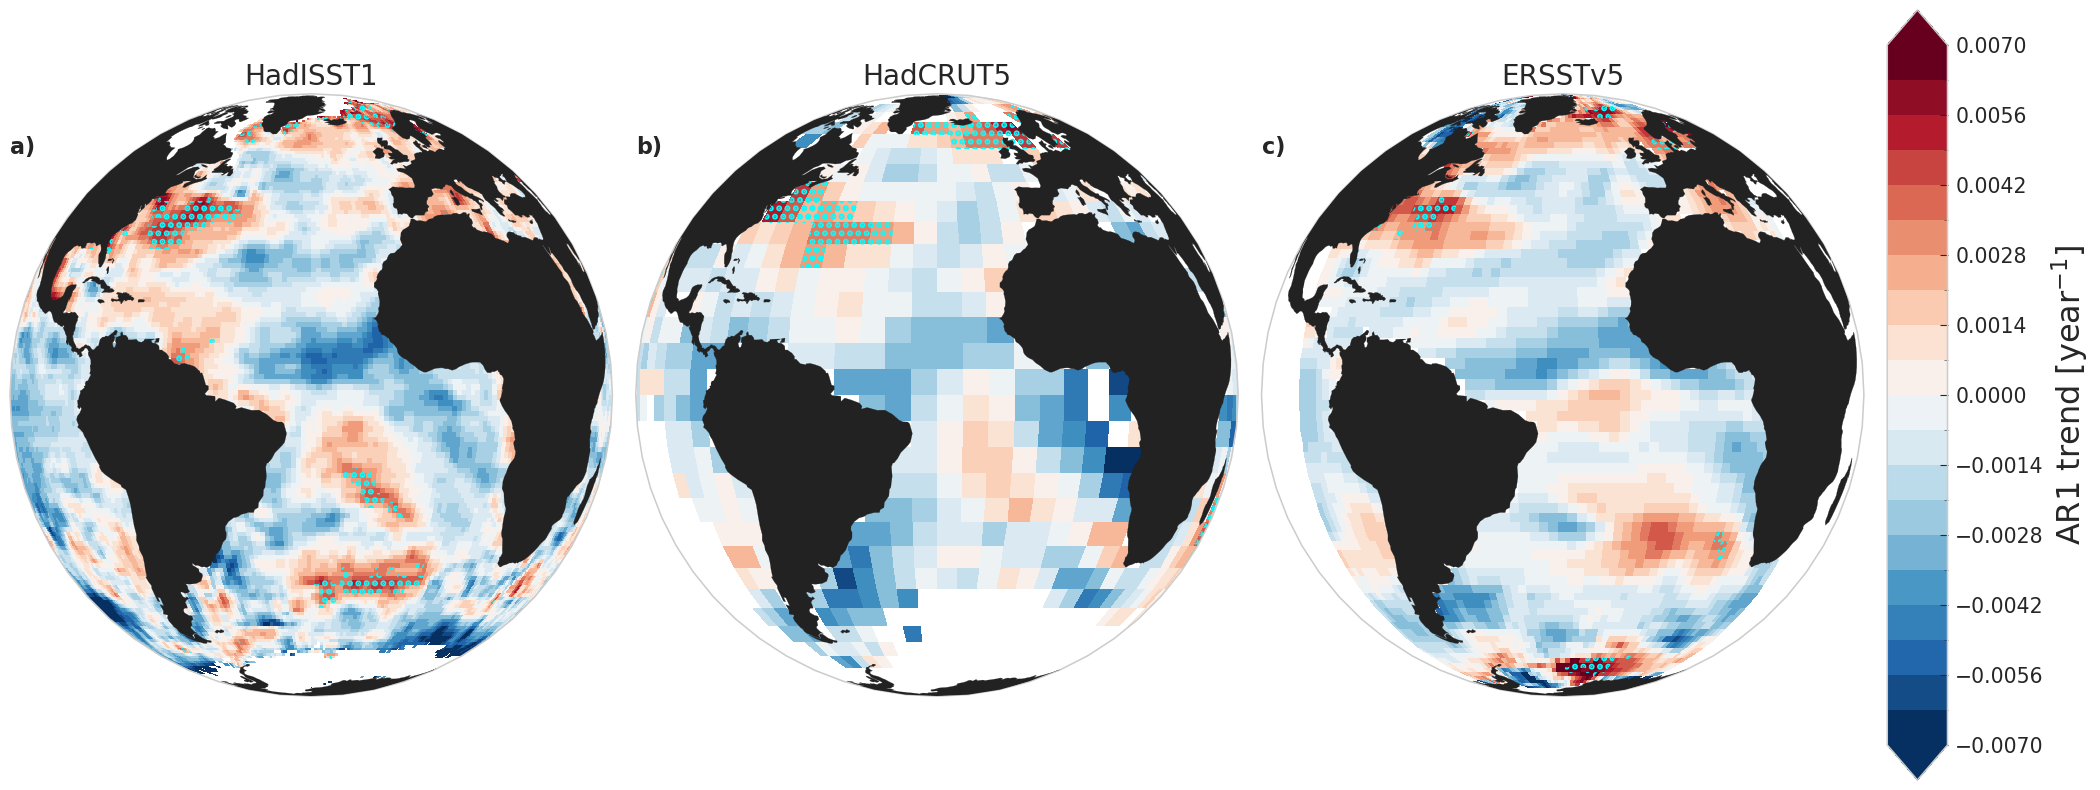

In [52]:
fig = plt.figure(figsize=(25,10))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.007,0.007,21)
mpl.rcParams['hatch.color'] = 'cyan'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=4,width_ratios=(1,1,1,0.1))

ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
ar1_Hmean_trend.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

ar1_Hsig.plot.contourf(levels = [-100,100], x = "longitude",   y = "latitude",corner_mask=False,hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('HadISST1',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
ar1_Cmean_trend.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

ar1_Csig.plot.contourf(levels = [-100,100],hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('HadCRUT5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')


ax = fig.add_subplot(gs[0,2], projection=ccrs.Orthographic(central_longitude=330))
ar1_Emean_trend.plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

ar1_Esig.plot.contourf(levels = [-100,100],hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('ERSSTv5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'c)',transform=ax.transAxes,fontweight='bold')

    
cax = fig.add_subplot(gs[0,3])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='AR1 trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0.05)
fig.savefig('AMOC_uncertainties/plots/SST_significance_ar1.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/SST_significance_ar1.pdf',bbox_inches='tight')
plt.show()

### std

In [53]:
# ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/fsurrogates_HadISST_dt50_at_stds_w60_ndt_trends.nc')
# trends = ds.lams_polyfit_coefficients.sel(degree=1)
# d = std_Hmean_trend.expand_dims(dim='smps', axis=0)
# d['smps']=[100]
# trend_arr = xr.concat((trends,d),dim='smps')

# trend_pvs = 1- np.apply_along_axis(f, 2, trend_arr)/100
# pv_array = xr.Dataset(
#         data_vars = dict(pv=(['longitude','latitude'],trend_pvs)),
#         coords = dict(
#                 latitude = d.latitude,
#         longitude = d.longitude))
# std_Hlam_significant = pv_array.pv.where(pv_array.pv<=0.05).where(pv_array.longitude<=30).where(pv_array.longitude>=-90)

In [54]:
# ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/correct_surrogates/HadCRUT_ar2_surrogates_dt20_mv_stds_w60_ndt_trends.nc')
# trends = ds.lams_polyfit_coefficients.sel(degree=1)
# d = std_Cmean_trend.transpose().expand_dims(dim='surrogates', axis=0)
# d['surrogates']=[1000]
# trend_arr = xr.concat((trends,d),dim='surrogates')
# trend_pvs = 1- np.apply_along_axis(f, 0, trend_arr)/100
# pv_array = xr.Dataset(
#         data_vars = dict(pv=(['latitude','longitude'],trend_pvs)),
#         coords = dict(
#                 latitude = d.latitude,
#         longitude = d.longitude))
# std_Csignificant = pv_array.pv.where(pv_array.pv<=0.05)


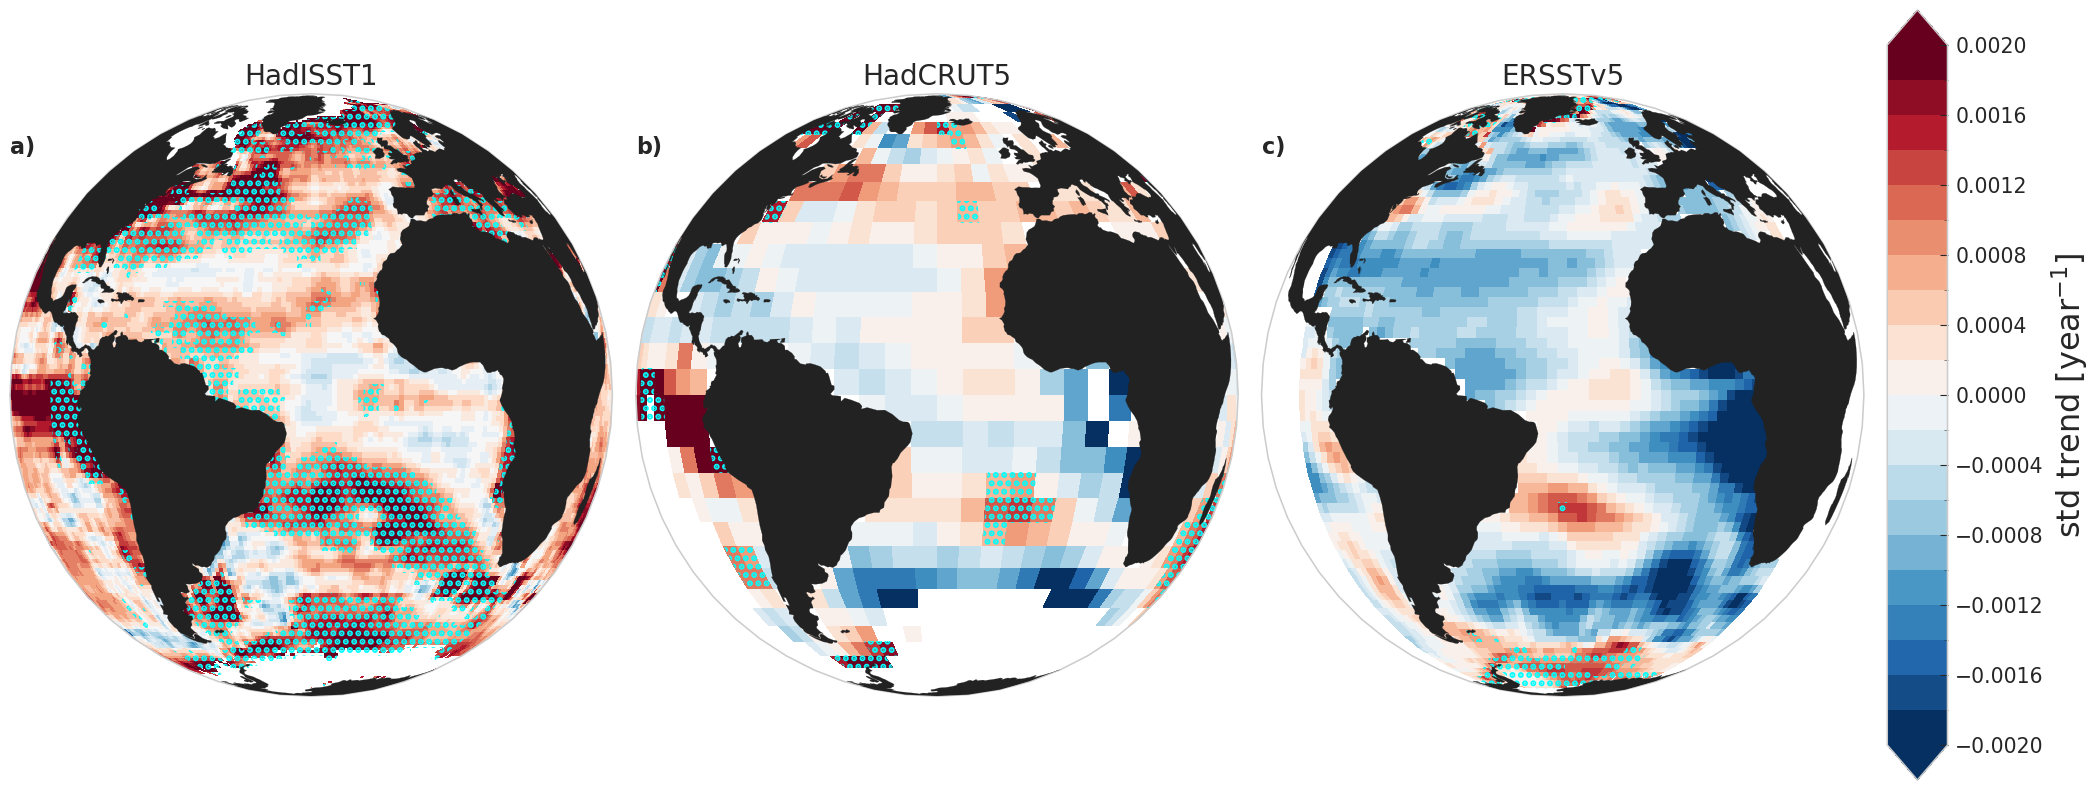

In [55]:
fig = plt.figure(figsize=(25,10))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.002,0.002,21)
mpl.rcParams['hatch.color'] = 'cyan'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=4,width_ratios=(1,1,1,0.1))

ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
std_Hmean_trend.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

std_Hsig.plot.contourf(levels = [-100,100], x = "longitude",   y = "latitude",corner_mask=False,hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('HadISST1',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
std_Cmean_trend.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

std_Csig.plot.contourf(levels = [-100,100],hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('HadCRUT5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')


ax = fig.add_subplot(gs[0,2], projection=ccrs.Orthographic(central_longitude=330))
std_Emean_trend.plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

std_Esig.plot.contourf(levels = [-100,100],hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('ERSSTv5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'c)',transform=ax.transAxes,fontweight='bold')

    
cax = fig.add_subplot(gs[0,3])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='std trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0.05)
fig.savefig('AMOC_uncertainties/plots/SST_significance_std.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/SST_significance_std.pdf',bbox_inches='tight')
plt.show()

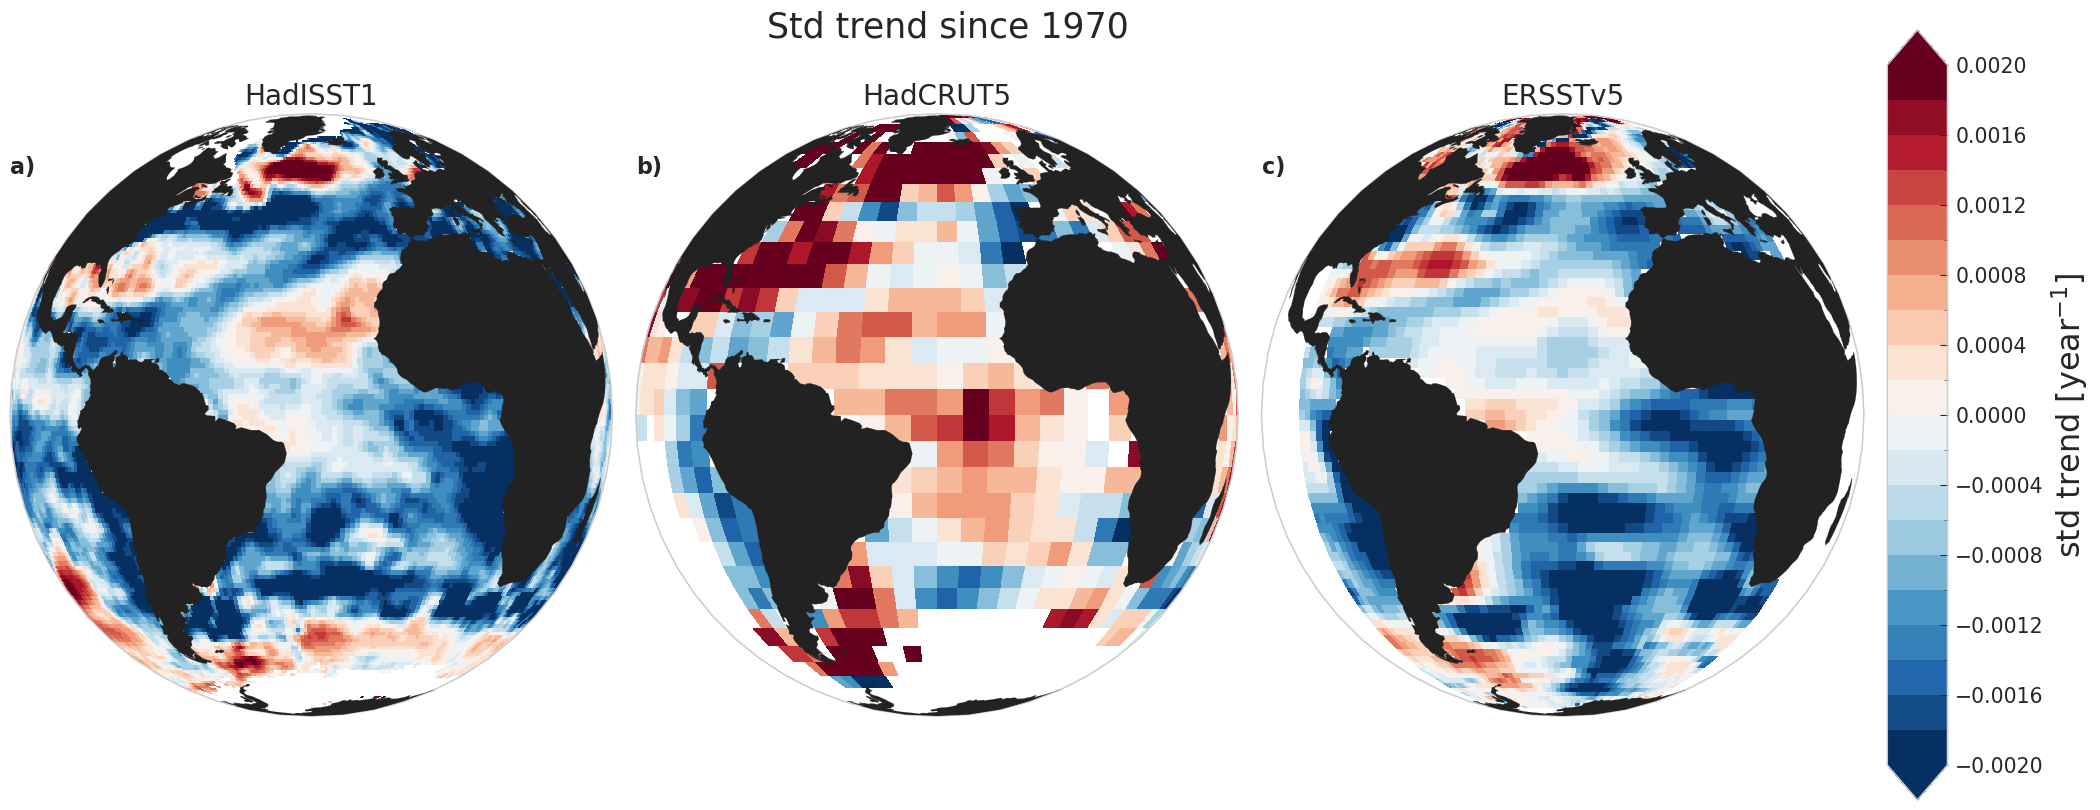

In [56]:
fig = plt.figure(figsize=(25,10))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.002,0.002,21)
mpl.rcParams['hatch.color'] = 'cyan'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=4,width_ratios=(1,1,1,0.1))

ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
std_Hmean_trend70.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

ax.set_global()
ax.set_title('HadISST1',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
std_Cmean_trend70.plot(
    x = "longitude", 
    y = "latitude",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

ax.set_global()
ax.set_title('HadCRUT5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')


ax = fig.add_subplot(gs[0,2], projection=ccrs.Orthographic(central_longitude=330))
std_Emean_trend70.plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

ax.set_global()
ax.set_title('ERSSTv5',fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'c)',transform=ax.transAxes,fontweight='bold')

    
cax = fig.add_subplot(gs[0,3])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='std trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0.05)
# fig.savefig('AMOC_uncertainties/plots/SST_significance_std.png',bbox_inches='tight')
fig.suptitle('Std trend since 1970',fontsize=25,y=0.9)
plt.show()

## Salinity surrogates maps

In [57]:
dmeany_wei = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/weights_dmean_ymean_at.nc').salinity_observation_weights.squeeze()[:-1]
y005 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.05))).sum(dim='time')
y05 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.5))).sum(dim='time')
y03 = abs(np.sign(dmeany_wei.where(dmeany_wei>=0.3))).sum(dim='time')

### ar1

In [58]:
ar1s = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_ar1s2_w60_runmean.nc').lambdas
true_ar1_trend = ar1s[:,30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

ar1_ndt05_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_ar1s2_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ar1_ndt05_sig = get_significance(true_ar1_trend,ar1_ndt05_trends,edim='surrogates')

ar1_ndt_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_ar1s2_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ar1_ndt_sig = get_significance(true_ar1_trend,ar1_ndt_trends,edim='surrogates',mdims=['lon','lat'])

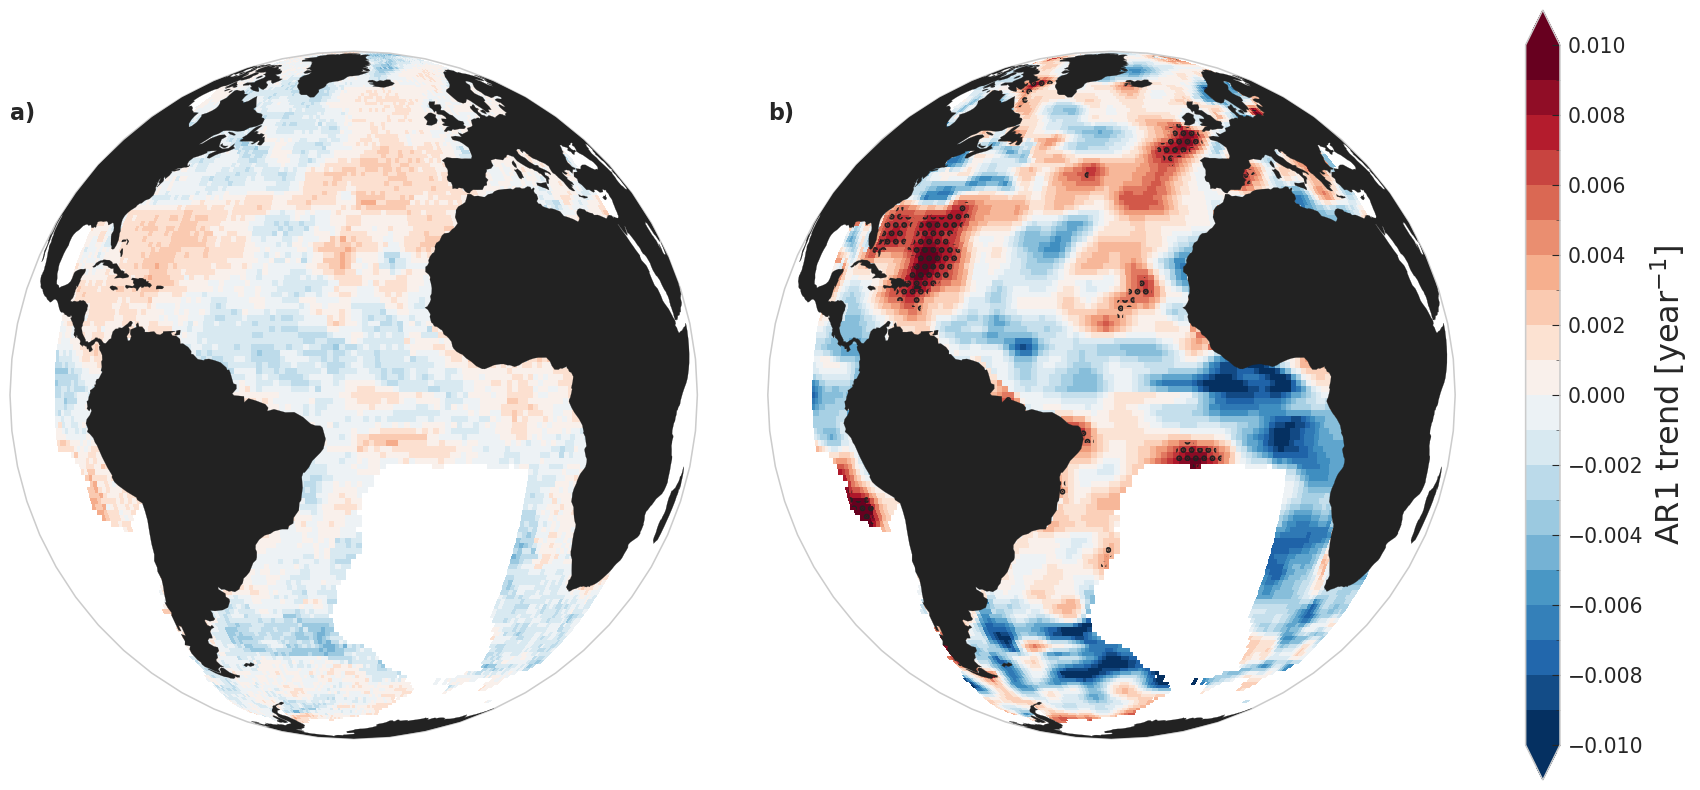

In [59]:
fig = plt.figure(figsize=(20,10))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.01,0.01,21)
mpl.rcParams['hatch.color'] = 'k'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=3,width_ratios=(1,1,0.05))

ttls = ['EN4.2.2 Salinity\nAR(2) surrogates','EN4.2.2 Salinity\nModified AR(2) surrogates']

ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
ar1_ndt05_trends.mean(dim='surrogates').where(y005>=60).plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

# ar1_ndt_sig.where(y005>=60).plot.contourf(x='lon',y='lat',levels = [-100,100],corner_mask=False,hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
ax.set_title('')
# ax.set_title(ttls[0],fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
true_ar1_trend.where(y005>=60).plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)


ar1_ndt05_sig.where(y005>=60).plot.contourf(levels = [-100,100],hatches=['..'],corner_mask=False,colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
# ax.set_title(ttls[1],fontsize=20)
# ax.set_title(ttls[1],fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')


cax = fig.add_subplot(gs[0,2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='AR1 trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0.15)
fig.savefig('AMOC_uncertainties/plots/salinity_significance_ar1.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/salinity_significance_ar1.pdf',bbox_inches='tight')
plt.show()

### std

In [60]:
stds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_stds_w60_runmean.nc').lambdas
true_std_trend = stds.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

std_ndt05_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_stds_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
std_ndt05_sig = get_significance(true_std_trend,std_ndt05_trends,edim='surrogates')

std_ndt_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_stds_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
std_ndt_sig = get_significance(true_std_trend,std_ndt_trends,edim='surrogates',mdims=['lon','lat'])

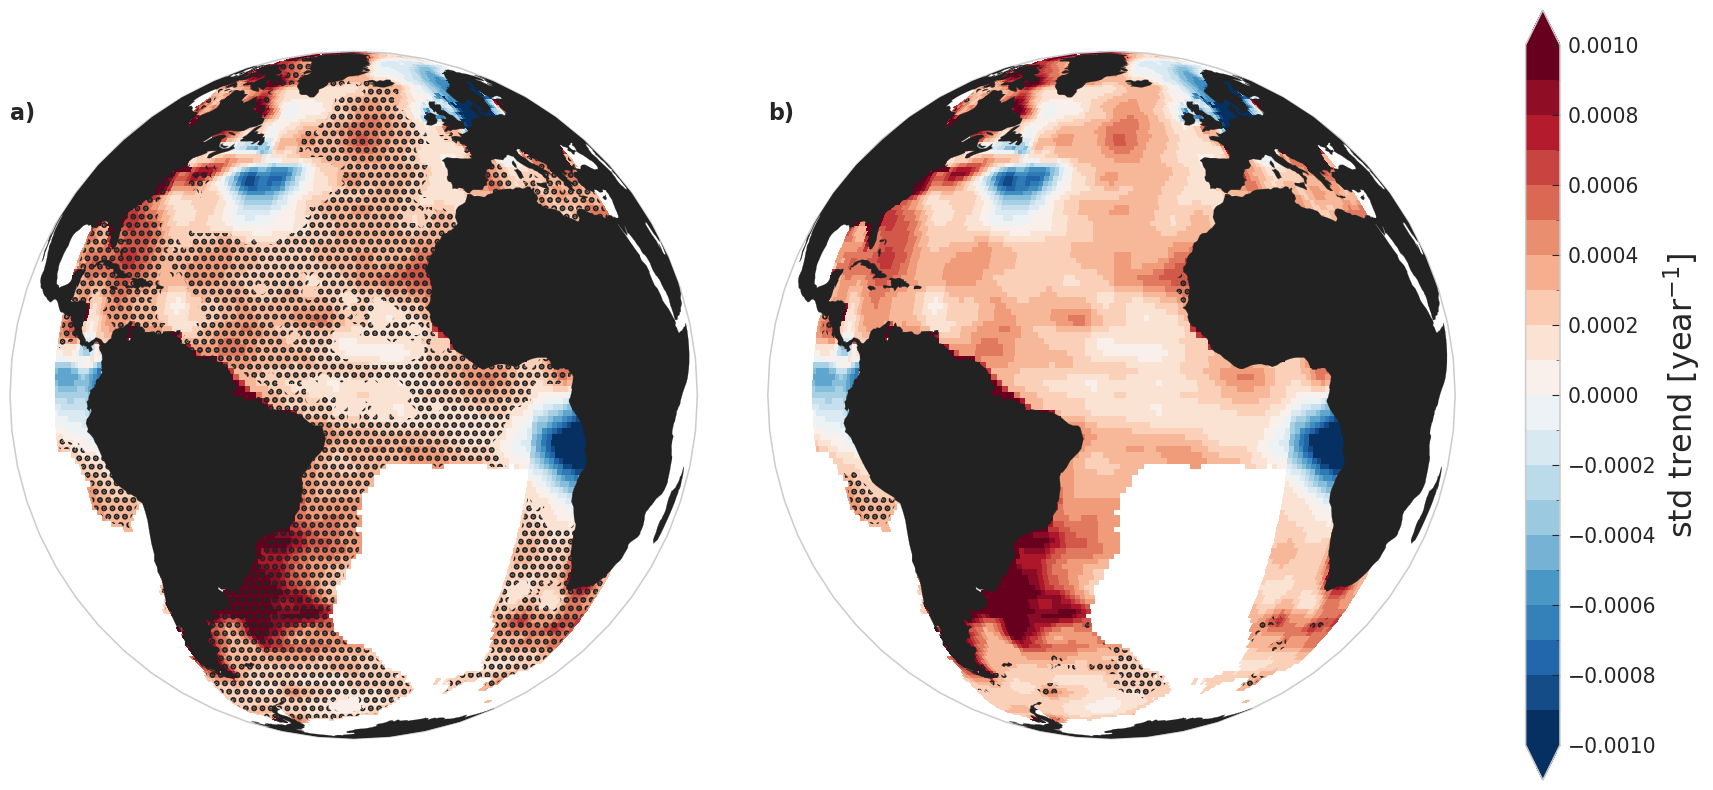

In [61]:
fig = plt.figure(figsize=(20,10))
colorss = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac'][::-1]
levelss = np.linspace(-0.001,0.001,21)
mpl.rcParams['hatch.color'] = 'k'
mpl.rcParams['hatch.linewidth'] = 3

gs = fig.add_gridspec(nrows=1, ncols=3,width_ratios=(1,1,0.05))

ttls = ['EN4.2.2 Salinity\nAR(2) surrogates','EN4.2.2 Salinity\nModified AR(2) surrogates']

ax = fig.add_subplot(gs[0,0], projection=ccrs.Orthographic(central_longitude=330))
true_std_trend.where(y005>=60).plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

std_ndt_sig.where(y005>=60).plot.contourf(x='lon',y='lat',levels = [-100,100],hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
# ax.set_title(ttls[0],fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'a)',transform=ax.transAxes,fontweight='bold')

ax = fig.add_subplot(gs[0,1], projection=ccrs.Orthographic(central_longitude=330))
true_std_trend.where(y005>=60).plot(
    x = "lon", 
    y = "lat",
    ax = ax,
    levels=levelss,
cmap =  plt.cm.RdBu_r,
                         add_colorbar=False,
    transform = ccrs.PlateCarree()
)

std_ndt05_sig.where(y005>=60).plot.contourf(levels = [-100,100],hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ax.set_global()
# ax.set_title(ttls[1],fontsize=20)
# ax.set_title(ttls[1],fontsize=20)
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.text(0,0.9,'b)',transform=ax.transAxes,fontweight='bold')


cax = fig.add_subplot(gs[0,2])
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(levelss, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levelss[::2],boundaries=levelss,norm=norm,
                            orientation='vertical',label='std trend [year$^{-1}$]',extend='both')
fig.subplots_adjust(hspace=0.05,wspace=0.15)
fig.savefig('AMOC_uncertainties/plots/salinity_significance_std.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/salinity_significance_std.pdf',bbox_inches='tight')
plt.show()

## significance regions

In [62]:
# Clats = std_Csignificant.latitude
# Clons = std_Csignificant.longitude
# shifted_sig = np.full((len(Clats),len(Clons)),np.nan)
# for i, lat in enumerate(Clats):
#     for j, lon in enumerate(Clons):
#         x = std_Csignificant.sel(latitude=lat,longitude=lon).values
#         if not np.isnan(x):
#             shifted_sig[i,j]=x
#             shifted_sig[i,j+1]=x
#             shifted_sig[i+1,j]=x
#             shifted_sig[i+1,j+1]=x
# std_Csig = xr.Dataset(
#                 data_vars = dict(pv=(['latitude','longitude'],shifted_sig)),
#                 coords = dict(
#                         latitude = Clats-2.5,
#                 longitude = Clons-2.5))

In [63]:
# Clats = ar1_Csignificant.latitude
# Clons = ar1_Csignificant.longitude
# shifted_sig = np.full((len(Clats),len(Clons)),np.nan)
# for i, lat in enumerate(Clats):
#     for j, lon in enumerate(Clons):
#         x = ar1_Csignificant.sel(latitude=lat,longitude=lon).values
#         if not np.isnan(x):
#             shifted_sig[i,j]=x
#             shifted_sig[i,j+1]=x
#             shifted_sig[i+1,j]=x
#             shifted_sig[i+1,j+1]=x
# ar1_Csig = xr.Dataset(
#                 data_vars = dict(pv=(['latitude','longitude'],shifted_sig)),
#                 coords = dict(
#                         latitude = Clats-2.5,
#                 longitude = Clons-2.5))

In [64]:
# Hlats = std_Hlam_significant.latitude
# Hlons = std_Hlam_significant.longitude
# shifted_sig = np.full((len(Hlats),len(Hlons)),np.nan)
# for i, lat in enumerate(Hlats):
#     for j, lon in enumerate(Hlons):
#         x = std_Hlam_significant.sel(latitude=lat,longitude=lon).values
#         if not np.isnan(x):
#             if (i!=179) & (j!=359):
#                 shifted_sig[i,j]=x
#                 shifted_sig[i,j+1]=x
#                 shifted_sig[i+1,j]=x
#                 shifted_sig[i+1,j+1]=x
#             else:
#                 if (i==179) & (j!=359):
#                     shifted_sig[0,j]=x
#                     shifted_sig[0,j+1]=x
#                 elif (j==359)&(i!=179):
#                     shifted_sig[i,0]=x
#                     shifted_sig[i+1,0]=x
#                 else:
#                     print(i,j)
#                     shifted_sig[0,0]=x
# std_Hsig = xr.Dataset(
#                 data_vars = dict(pv=(['latitude','longitude'],shifted_sig)),
#                 coords = dict(
#                         latitude = Hlats-0.5,
#                 longitude = Hlons-0.5))

In [65]:
# Hlats = ar1_Hlam_significant.latitude
# Hlons = ar1_Hlam_significant.longitude
# shifted_sig = np.full((len(Hlats),len(Hlons)),np.nan)
# for i, lat in enumerate(Hlats):
#     for j, lon in enumerate(Hlons):
#         x = ar1_Hlam_significant.sel(latitude=lat,longitude=lon).values
#         if not np.isnan(x):
#             if (i!=179) & (j!=359):
#                 shifted_sig[i,j]=x
#                 shifted_sig[i,j+1]=x
#                 shifted_sig[i+1,j]=x
#                 shifted_sig[i+1,j+1]=x
#             else:
#                 if (i==179) & (j!=359):
#                     shifted_sig[0,j]=x
#                     shifted_sig[0,j+1]=x
#                 elif (j==359)&(i!=179):
#                     shifted_sig[i,0]=x
#                     shifted_sig[i+1,0]=x
#                 else:
#                     print(i,j)
#                     shifted_sig[0,0]=x
# ar1_Hsig = xr.Dataset(
#                 data_vars = dict(pv=(['latitude','longitude'],shifted_sig)),
#                 coords = dict(
#                         latitude = Hlats-0.5,
#                 longitude = Hlons-0.5))

In [66]:
# Slats = ar1_ndt05_sig.lat
# Slons = ar1_ndt05_sig.lon
# shifted_sig = np.full((len(Slats),len(Slons)),np.nan)
# for i, lat in enumerate(Slats):
#     for j, lon in enumerate(Slons):
#         x = ar1_ndt05_sig.sel(lat=lat,lon=lon).values
#         if not np.isnan(x):
#             if (i!=172) & (j!=120):
#                 shifted_sig[i,j]=x
#                 shifted_sig[i,j+1]=x
#                 shifted_sig[i+1,j]=x
#                 shifted_sig[i+1,j+1]=x
#             else:
#                 if (i==172) & (j!=120):
#                     shifted_sig[0,j]=x
#                     shifted_sig[0,j+1]=x
#                 elif (j==120)&(i!=172):
#                     shifted_sig[i,0]=x
#                     shifted_sig[i+1,0]=x
#                 else:
#                     print(i,j)
#                     shifted_sig[0,0]=x
# ar1_Ssig = xr.Dataset(
#                 data_vars = dict(pv=(['lat','lon'],shifted_sig)),
#                 coords = dict(
#                         lat = Slats-0.5,
#                 lon = Slons-0.5))

In [67]:
# Slats = std_ndt05_sig.lat
# Slons = std_ndt05_sig.lon
# shifted_sig = np.full((len(Slats),len(Slons)),np.nan)
# for i, lat in enumerate(Slats):
#     for j, lon in enumerate(Slons):
#         x = std_ndt05_sig.sel(lat=lat,lon=lon).values
#         if not np.isnan(x):
#             if (i!=172) & (j!=120):
#                 shifted_sig[i,j]=x
#                 shifted_sig[i,j+1]=x
#                 shifted_sig[i+1,j]=x
#                 shifted_sig[i+1,j+1]=x
#             else:
#                 if (i==172) & (j!=120):
#                     shifted_sig[0,j]=x
#                     shifted_sig[0,j+1]=x
#                 elif (j==120)&(i!=172):
#                     shifted_sig[i,0]=x
#                     shifted_sig[i+1,0]=x
#                 else:
#                     print(i,j)
#                     shifted_sig[0,0]=x
# std_Ssig = xr.Dataset(
#                 data_vars = dict(pv=(['lat','lon'],shifted_sig)),
#                 coords = dict(
#                         lat = Slats-0.5,
#                 lon = Slons-0.5))

### ar1

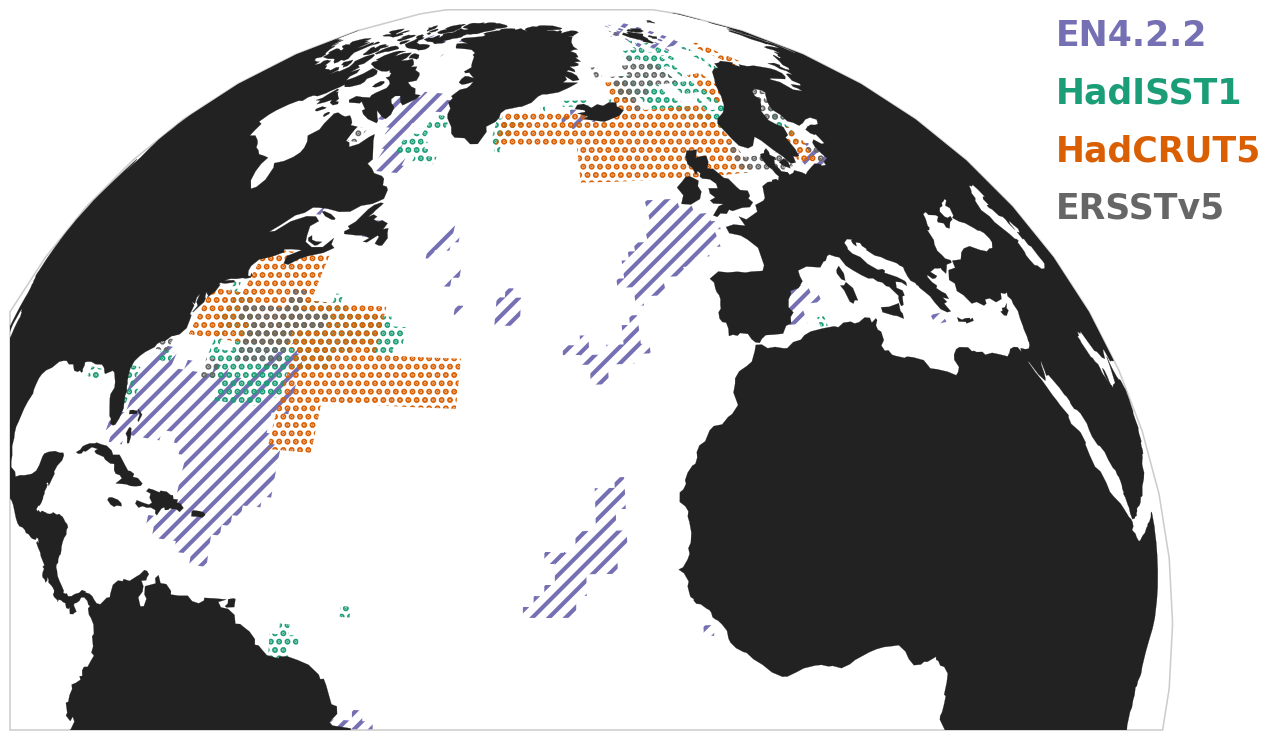

In [68]:
fig = plt.figure(figsize=(15,15))
levelss = np.linspace(-0.01,0.01,21)
mpl.rcParams['hatch.linewidth'] = 3


ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=330,central_latitude=10))
levelss = np.linspace(0,0.4,21)

# ws.where(ws>0.05).plot(cmap =  plt.cm.Greys,levels=levelss,ax=ax,transform = ccrs.PlateCarree(),alpha=0.3,
#                   add_colorbar=False)

mpl.rcParams['hatch.color'] = 'C2'
ar1_Ssig.plot.contourf(levels = [-100,100],hatches=['//'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
mpl.rcParams['hatch.color'] = 'C0'
ar1_Hsig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",corner_mask=False,
                               hatches=['..'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
mpl.rcParams['hatch.color'] = 'C1'
ar1_Csig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",
                               hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
   
mpl.rcParams['hatch.color'] = 'C7'
ar1_Esig.plot.contourf(levels = [-100,100],
                                   x = "lon", 
                            y = "lat",
                               hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
 
ax.text(0.9,0.95,'EN4.2.2',transform=ax.transAxes,fontweight='bold',color='C2',fontsize=25)
ax.text(0.9,0.87,'HadISST1',transform=ax.transAxes,fontweight='bold',color='C0',fontsize=25)
ax.text(0.9,0.79,'HadCRUT5',transform=ax.transAxes,fontweight='bold',color='C1',fontsize=25)
ax.text(0.9,0.71,'ERSSTv5',transform=ax.transAxes,fontweight='bold',color='C7',fontsize=25)

ax.set_global()
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.set_title('')
ax.set_extent([-90, 90,0,90], crs=ccrs.PlateCarree())
fig.savefig('AMOC_uncertainties/plots/ar1_sig_regions.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/ar1_sig_regions.pdf',bbox_inches='tight')
# fig.suptitle('Regions of significant AR1 increase in the North Atlantic',fontsize=25,y=0.79)
plt.show()

In [69]:
Hlams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/HadISST_lambdas_w60_rmean.nc').lams
Hlams['time']=np.arange(1870,2021)
Hmean_trend = Hlams[:,30:-30].polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/obs_data/fsurrogates_HadISST_dt50_lams_w60_ndt_100_trends.nc')
trends = ds.lams_polyfit_coefficients.sel(degree=1)
d = Hmean_trend.expand_dims(dim='smps', axis=0)
d['smps']=[100]
trend_arr = xr.concat((trends,d),dim='smps')

trend_pvs = 1- np.apply_along_axis(f, 2, trend_arr)/100
pv_array = xr.Dataset(
        data_vars = dict(pv=(['longitude','latitude'],trend_pvs)),
        coords = dict(
                lat = d.latitude,
        lon = d.longitude))
Hlam_significant = pv_array.pv.where(pv_array.pv<=0.05)
surr_mu = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/correct_surrogates/HadCRUT_ar2_surrogates_dt20_mv_lambdas_w60_ndt_full_stats.nc').mu
Clambda_trend = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/mean_lambdas_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/correct_surrogates/HadCRUT_ar2_surrogates_dt20_mv_lambdas_w60_ndt_full_trends.nc')
trends = ds.lams_polyfit_coefficients.sel(degree=1)
d = Clambda_trend.transpose().expand_dims(dim='surrogates', axis=0)
d['surrogates']=[1000]
trend_arr = xr.concat((trends,d),dim='surrogates')
trend_pvs = 1- np.apply_along_axis(f, 0, trend_arr)/100
pv_array = xr.Dataset(
        data_vars = dict(pv=(['latitude','longitude'],trend_pvs)),
        coords = dict(
                latitude = d.latitude,
        longitude = d.longitude))
Csignificant = pv_array.pv.where(pv_array.pv<=0.05)
ds = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/salinity_lambdas_w60_runmean.nc').lambdas
true_lam_trend = ds.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)

ndt05_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_lams_full_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
# ndt05_mu = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_elim05_lams_full_w60_ndt_stats.nc').mu
ndt05_sig = get_significance(true_lam_trend,ndt05_trends,edim='surrogates')

ndt_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_lams_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
# ndt_mu = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ENS4_analyses/fake_ar2_data2_dt20_surrs_lams_w60_ndt_stats.nc').mu
ndt_sig = get_significance(true_lam_trend,ndt_trends,edim='surrogates',mdims=['lon','lat'])

## ar1 and lambda

In [70]:
Spos = true_lam_trend.where((true_lam_trend>=0)&(true_ar1_trend>=0))
Cpos = Clambda_trend.where((Clambda_trend>=0)&(ar1_Cmean_trend>=0))
Hpos = Hmean_trend.where((Hmean_trend>=0)&(ar1_Hmean_trend>=0))

In [71]:
Csig = xr.open_dataset('Csig.nc').pv
Hsig = xr.open_dataset('Hsig.nc').pv
Ssig = xr.open_dataset('Ssig.nc').pv
Esig = xr.open_dataset('Esig.nc').pv

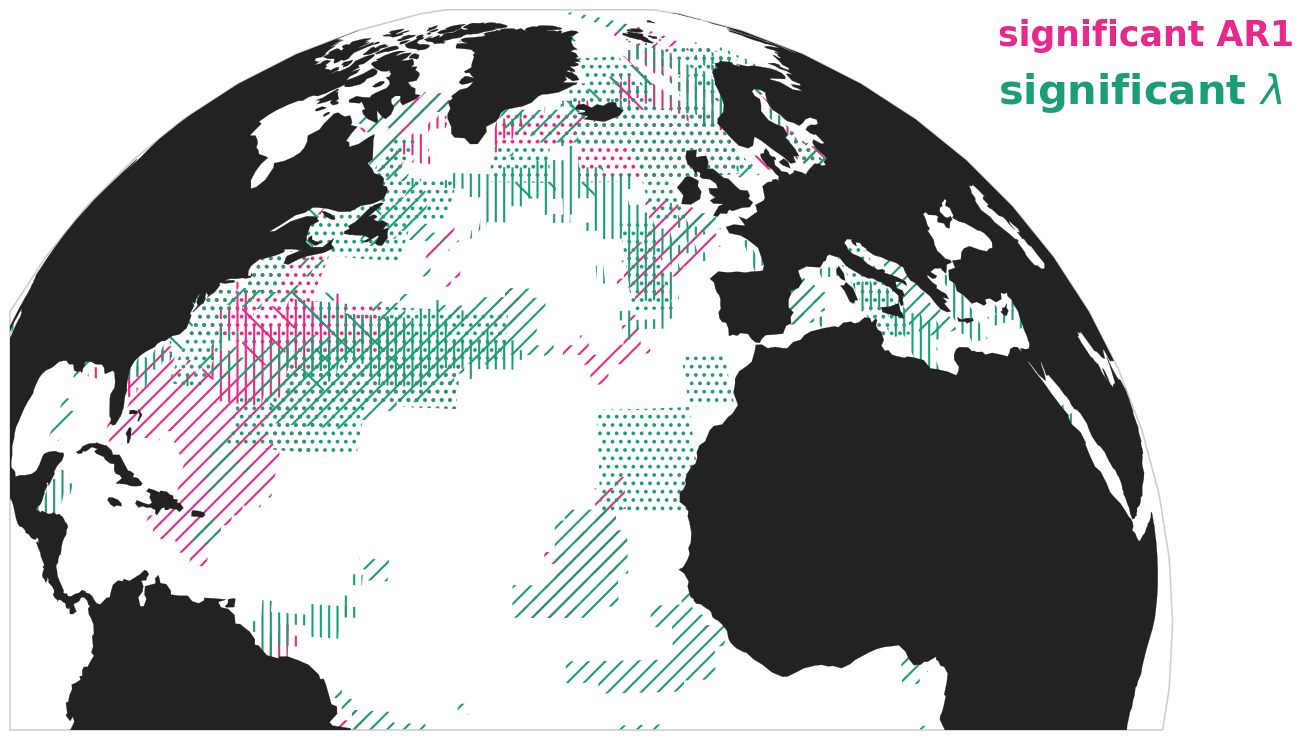

In [72]:
fig = plt.figure(figsize=(15,15))
levelss = np.linspace(-0.01,0.01,21)
mpl.rcParams['hatch.linewidth'] = 1.5


ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=330,central_latitude=10))
levelss = np.linspace(0,0.4,21)

# ws.where(ws>0.05).plot(cmap =  plt.cm.Greys,levels=levelss,ax=ax,transform = ccrs.PlateCarree(),alpha=0.3,
#                   add_colorbar=False)
# Spos.plot(levels = [-100,100],colors=['k','k'],alpha=0.05,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
# Cpos.plot(x='longitude',y='latitude',levels = [-100,100],colors=['k','k'],alpha=0.05,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
# Hpos.plot(x='longitude',y='latitude',levels = [-100,100],colors=['k','k'],alpha=0.05,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())

mpl.rcParams['hatch.color'] = 'C3'
ar1_Ssig.plot.contourf(levels = [-100,100],hatches=['//'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ar1_Hsig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",corner_mask=False,
                               hatches=['||'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ar1_Csig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",
                               hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
ar1_Esig.plot.contourf(levels = [-100,100],
                                   x = "lon", 
                            y = "lat",
                               hatches=['\\'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())


mpl.rcParams['hatch.color'] = 'C0'
Ssig.plot.contourf(levels = [-100,100],hatches=['//'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
Hsig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",corner_mask=False,
                               hatches=['||'],colors='none',add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
Csig.plot.contourf(levels = [-100,100],
                                   x = "longitude", 
                            y = "latitude",
                               hatches=['..'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())
Esig.plot.contourf(levels = [-100,100],
                                   x = "lon", 
                            y = "lat",
                               hatches=['\\'],colors='none',corner_mask=False,add_colorbar=False,ax=ax,transform = ccrs.PlateCarree())


ax.text(0.85,0.95,'significant AR1',transform=ax.transAxes,fontweight='bold',color='C3',fontsize=25)
ax.text(0.85,0.87,'significant $\lambda$',transform=ax.transAxes,fontweight='bold',color='C0',fontsize=30)
# ax.text(0.85,0.8,'both have positive trend',transform=ax.transAxes,color='grey',fontsize=20)

ax.set_global()
ax.add_feature(cartopy.feature.LAND, edgecolor='black',color='k',zorder=20)
ax.set_title('')
ax.set_extent([-90, 90,0,90], crs=ccrs.PlateCarree())
fig.savefig('AMOC_uncertainties/plots/both_sig_regions.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/both_sig_regions.pdf',bbox_inches='tight')
# fig.suptitle('Regions of significant AR1 and $\lambda$ increase in the North Atlantic',fontsize=25,y=0.8)
plt.show()

## indices

In [73]:
def get_pvs(mean_trends,surr_trends,edim='surrogates',mdims=['smps','member'],axis=2):
    d = mean_trends.expand_dims(dim=edim, axis=0)
    d[edim]=[len(surr_trends[edim])]
    trend_arr = xr.concat((surr_trends,d),dim=edim)
    trend_pvs = 1- np.apply_along_axis(f, axis, trend_arr)/100
    pv_array = (mean_trends.copy(data=trend_pvs)).to_dataset(name='pv')
    return pv_array

In [74]:
amocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_ymeancon.nc').samples[:,:-1]
amoc = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadSST/HadSST.4.0.1.0_median_amoc.nc').tos.squeeze()[:-2]
amocy = yearly_avg(amoc)

### ar1

In [75]:
ar1_smpl_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_fsurrogates_dt50_ar1s2_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ar1_amc = ar1_wrapper_rmean(amocy.values[23:],ws=60)
ar1s_amc = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_ar1s2_w60_runmean.nc').lams
ar1_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_ar1s2_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
ar1_ttrend = st.linregress(np.arange(ar1_amc[30:-30].shape[0]), ar1_amc[30:-30])[0]
ar1_pv_array=get_pvs(ar1_trends,ar1_smpl_surr_trends)

In [76]:
ar1_mean_surr_trends= xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadSST/lams/HadSST.4.0.1.0_median_amoc_fsurrogates_dt50_ar1s2_w60_rmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
data = ar1_mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
ar1_pv = 1-st.percentileofscore(data, ar1_ttrend)/100
print(ar1_pv)

0.4069999999999999


In [77]:
Camocy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean_SST_amoc_ymeancon.nc').tas_mean.squeeze()[:-1]
Camocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_ymeancon.nc').squeeze().tas

ar1_mem_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT_members_SST_fsurrogates_dt50_amoc_full_ar1s2_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)

Car1_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_ar1s2_w60_runmean.nc').lams
Car1_lam = ar1_wrapper_rmean(Camocy,ws=60)

Car1_trends=xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_ar1s2_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
Car1_ttrend = st.linregress(np.arange(Car1_lam[30:-30].shape[0]), Car1_lam[30:-30])[0]

Car1_pv_array = get_pvs(Car1_trends,ar1_mem_surr_trends,mdims=['member'],axis=1)

In [78]:
Car1_mean_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_median_SST_amoc_fsurrogates_dt50_ar1s2_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
data = Car1_mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
Car1_pv = 1-st.percentileofscore(data, Car1_ttrend)/100
print(Car1_pv)

0.481


In [79]:
Eamocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean.nc').sst
Eamocy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst.mnmean.1854.2017_ymean_amoc.nc').sst.squeeze()

Ear1_mem_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ar1s_w60_rmean.nc').lams
Ear1_mem_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ar1s_w60_rmean_trends.nc').polyfit_coefficients.sel(degree=1)

Ear1_mem_surr_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean_fsurrs_dt50_ar1s_w60_ndt_full.nc').lams
Ear1_mem_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean_fsurrs_dt50_ar1s_w60_ndt_full_trends.nc').polyfit_coefficients.sel(degree=1)

Ear1_lam = ar1_wrapper_rmean(Eamocy,ws=60)

Ear1_ttrend = st.linregress(np.arange(Ear1_lam[30:-30].shape[0]), Ear1_lam[30:-30])[0]

Ear1_pv_array = get_pvs(Ear1_mem_trends,Ear1_mem_surr_trends,mdims=['member'],axis=1)

Ear1_mean_surr_lams= xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst.mnmean.1854.2017_ymean_amoc_fsurrogates_dt50_ar1_w60_ndt.nc').surrs
Ear1_mean_surr_lams['time']=np.arange(1854,2018)
Ear1_mean_surr_trends = Ear1_mean_surr_lams.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
data = Ear1_mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
Ear1_pv = 1-st.percentileofscore(data, Ear1_ttrend)/100
print(Ear1_pv)

0.118


0.0003097960431779649 0.00027073955970535627 

0.0008413190875992384 0.0007593640987424712


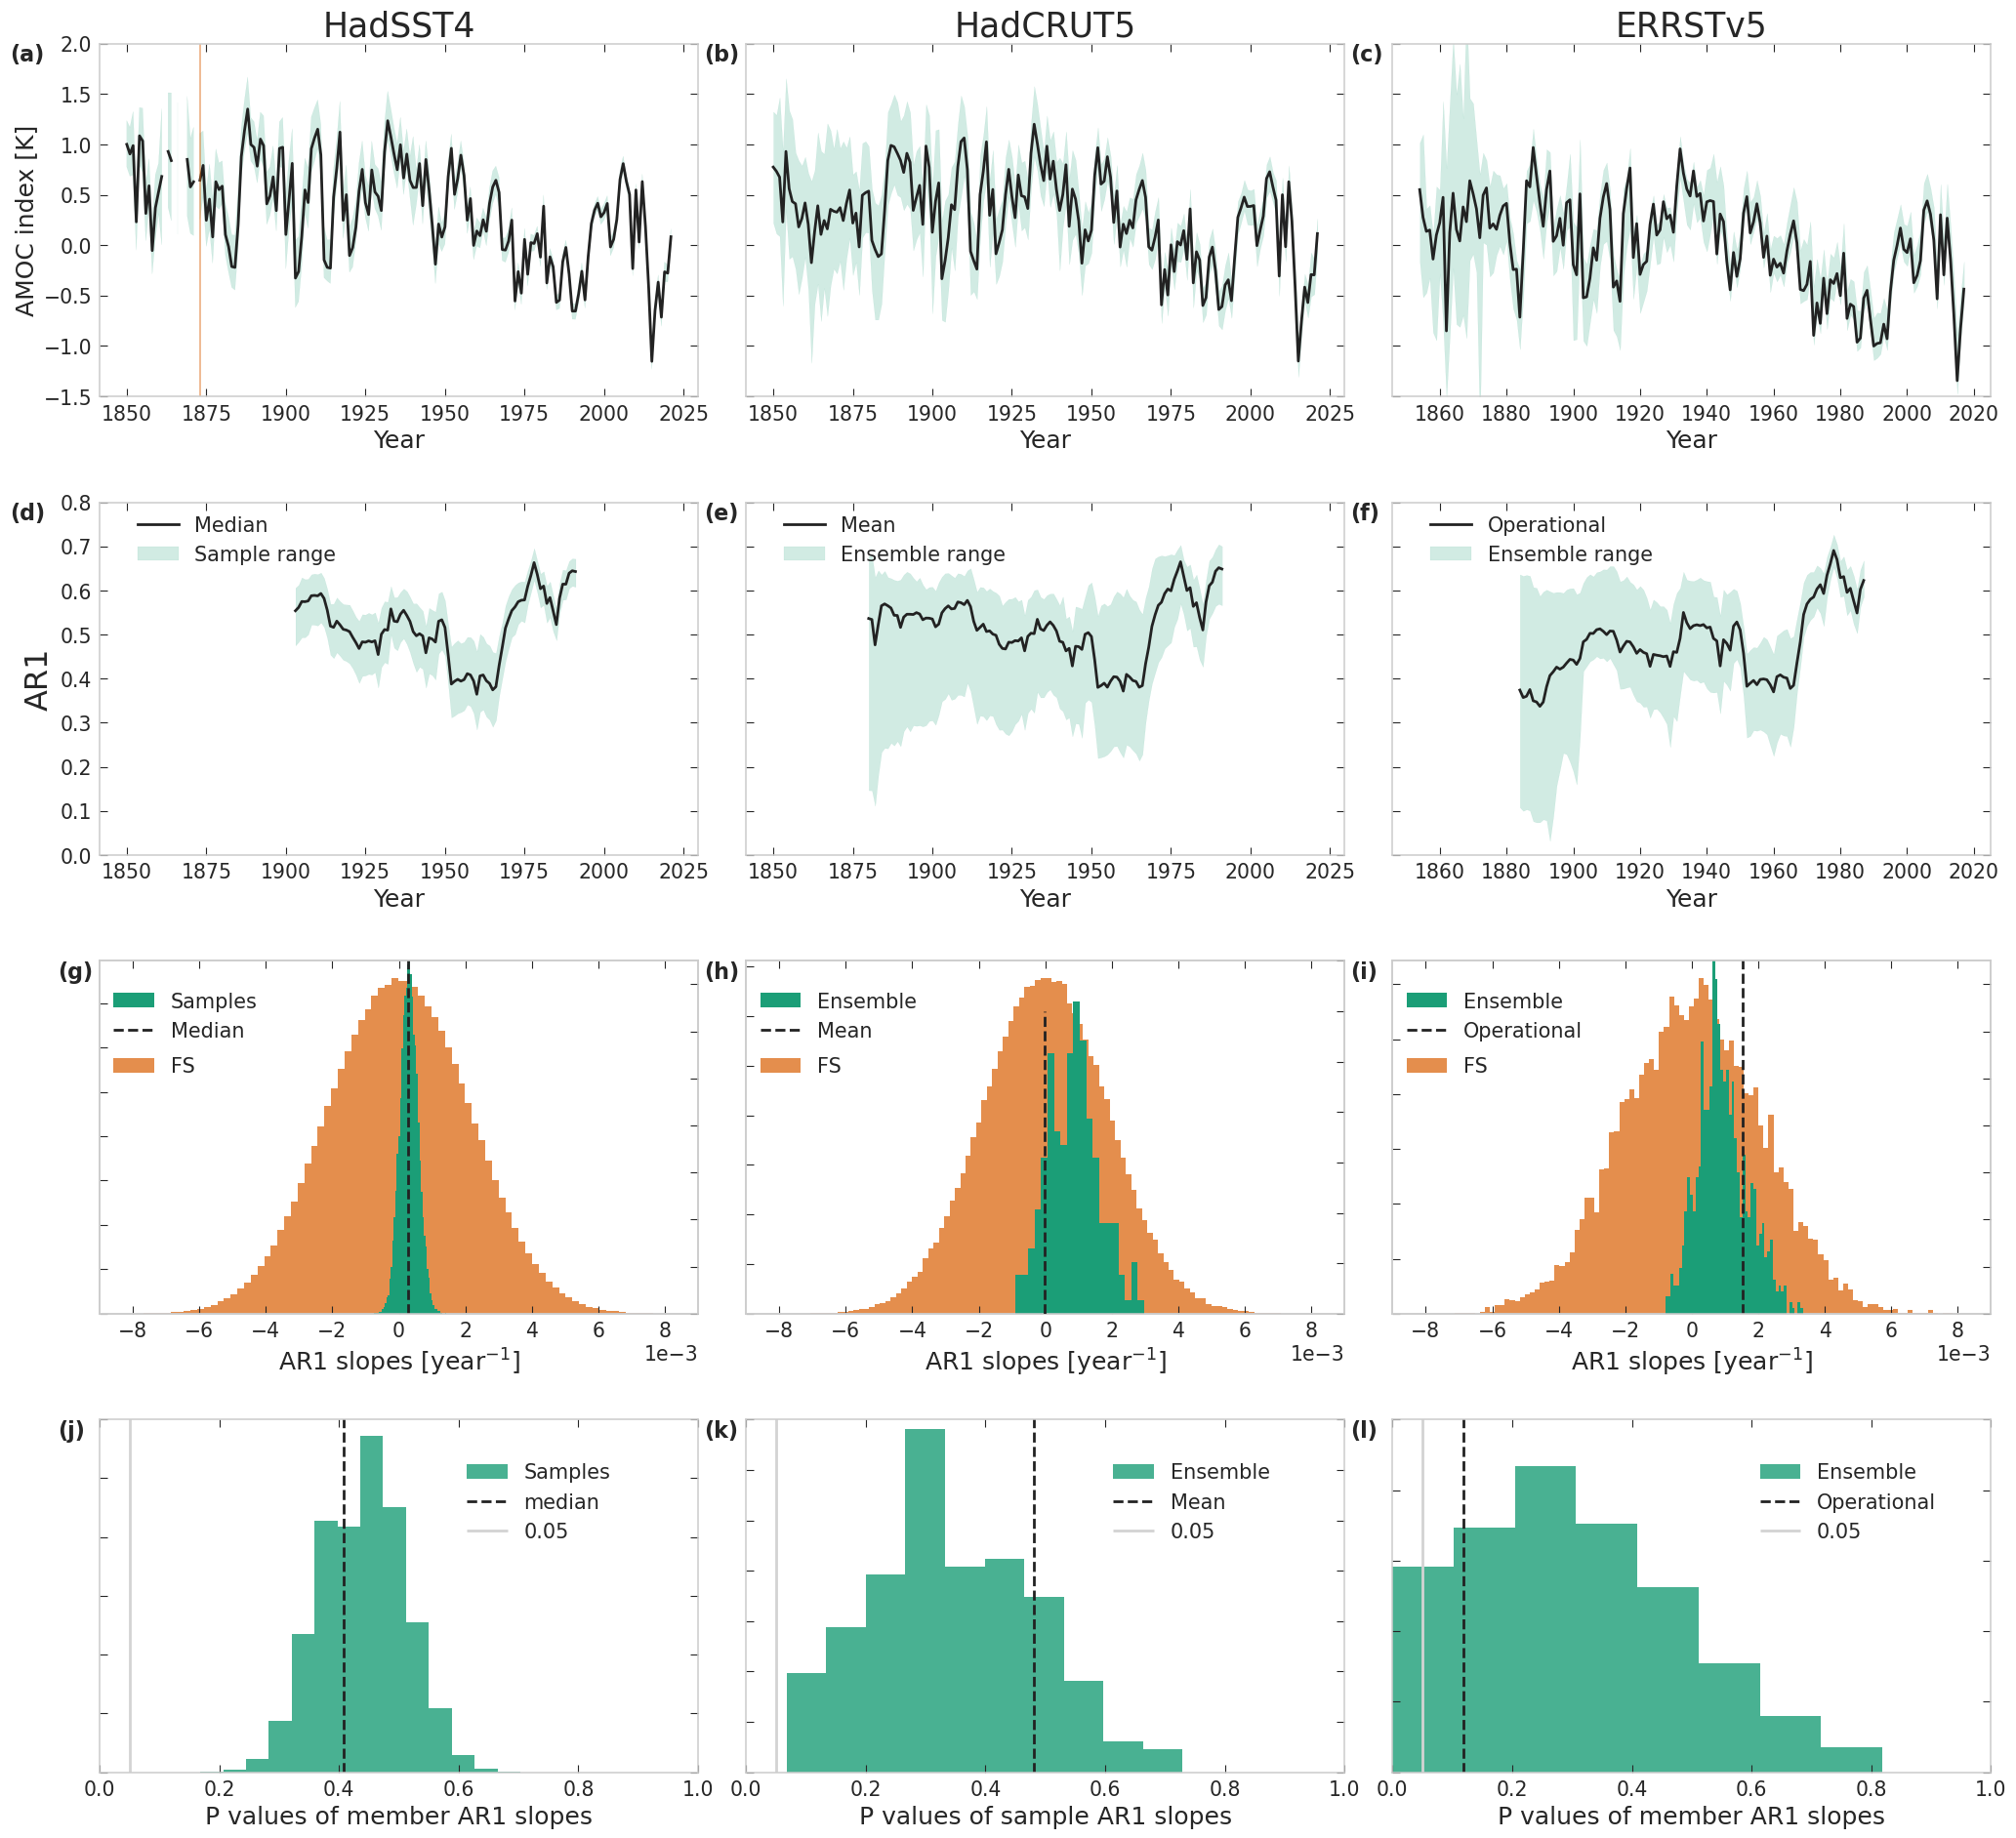

In [80]:
fig = plt.figure(figsize=(25,23))
lblsize =18
gs = fig.add_gridspec(nrows=4, ncols=3)

# HadCRUT5 amoc
ax = fig.add_subplot(gs[0,1])
tt = np.arange(1850,2022)
mx = Camocsy.max(dim='member').values
mn = Camocsy.min(dim='member').values
col = 'C0'
plt.plot(tt,Camocy, label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
# ax.set_ylabel('AMOC index [K]',fontsize=15)
ax.set_title('HadCRUT5',fontsize=25)
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.07,0.95,'(b)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadSST4 amoc
ax = fig.add_subplot(gs[0,0])
tt = np.arange(1850,2022)
mx = amocsy.max(dim='smps').max(dim='member').values
mn = amocsy.min(dim='smps').min(dim='member').values
col = 'C0'
plt.plot(tt,amocy, label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
ax.vlines(1850+23,-3,3,color='C1',alpha=0.5)
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
ax.set_ylabel('AMOC index [K]',fontsize=lblsize)
ax.set_title('HadSST4',fontsize=25)
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.15,0.95,'(a)',transform=ax.transAxes,fontweight='bold')

#HadSST4 lambda
ax = fig.add_subplot(gs[1,0],sharex=ax)
tt = np.arange(1873+30,2022-30)
mx = ar1s_amc.max(dim='smps').max(dim='member').values[30:-30]
mn = ar1s_amc.min(dim='smps').min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,ar1_amc[30:-30], label='Median',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Sample range')
ax.legend(bbox_to_anchor=(0.05, 0.8), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(0,0.8)
ax.set_ylabel('AR1')
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.15,0.95,'(d)',transform=ax.transAxes,fontweight='bold')

# HadCRUT5 lambda
ax = fig.add_subplot(gs[1,1],sharex=ax)
tt = np.arange(1850+30,2022-30)
mx = Car1_lams.max(dim='member').values[30:-30]
mn = Car1_lams.min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,Car1_lam[30:-30], label='Mean',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Ensemble range')
ax.legend(bbox_to_anchor=(0.05, 0.8), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(0,0.8)
# ax.set_ylabel('AR1')
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.07,0.95,'(e)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadSST4 trends
ax = fig.add_subplot(gs[2,0])
plt.hist(ar1_smpl_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(ar1_trends.values.ravel(),bins=50,color='C0',density=True,label='Samples')
ax.set_ylim(0,1500)
ax.vlines(ar1_ttrend,0,2000,color='k',linestyle='--',lw=2,label='Median'.format(ar1_ttrend,ar1_pv))
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_title("")
ax.set_yticklabels([])

(mu, sigma) = stats.norm.fit(ar1_trends.values.ravel())
print(mu,sigma,'\n')
xx = np.linspace(0.003,0.01,100)
# ax.set_xlim(0.0045,0.007)
# ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.75), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.set_xlim(-0.009,0.009)
ax.text(-0.07,0.95,'(g)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
# HadCRUT5 trends
ax = fig.add_subplot(gs[2,1])
nbins = 20
plt.hist(ar1_mem_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(Car1_trends.values.ravel(),bins=20,color='C0',density=True,label='Ensemble')
ax.set_ylim(0,700)
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
(mu, sigma) = stats.norm.fit(Car1_trends.values.ravel())
print(mu,sigma)
xx = np.linspace(0.001,0.01,100)
ax.set_xlim(-0.009,0.009)
ax.vlines(Car1_ttrend,0,600,color='k',linestyle='--',lw=2,label='Mean'.format(Car1_ttrend,Car1_pv),zorder=20)
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
# ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.75), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(h)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
# HadSST4 p values
ax = fig.add_subplot(gs[3,0])
plt.hist(ar1_pv_array.pv.values.ravel(),bins=14,density=True,color='C0',alpha=0.8,label='Samples')
ax.vlines(ar1_pv,0,40,color='k',linestyle='--',lw=2,label='median')
ax.set_ylim(0,6)
ax.vlines(0.05,0,40,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.set_xlabel("P values of member AR1 slopes",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.6, 0.63), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,1)
ax.text(-0.07,0.95,'(j)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadCRUT5 p values
ax = fig.add_subplot(gs[3,1])
plt.hist(Car1_pv_array.pv.values.ravel(),bins=10,density=True,color='C0',alpha=0.8,label='Ensemble')
ax.vlines(Car1_pv,0,20,color='k',linestyle='--',lw=2,label='Mean'.format(Car1_pv))
ax.vlines(0.05,0,20,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.text(-0.07,0.95,'(k)',transform=ax.transAxes,fontweight='bold')
ax.set_ylim(0,3.5)
ax.set_xlabel("P values of sample AR1 slopes",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.6, 0.63), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,1)
ax.set_yticklabels([])


# ERSST amoc
ax = fig.add_subplot(gs[0,2])
tt = np.arange(1854,2018)
mx = (Eamocsy-Eamocsy.mean(dim='time')).max(dim='member').values
mn = (Eamocsy-Eamocsy.mean(dim='time')).min(dim='member').values
col = 'C0'
plt.plot(tt,Eamocy-Eamocy.mean(), label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
# ax.set_ylabel('AMOC index [K]',fontsize=lblsize)
plt.xlabel('Year',fontsize=lblsize)
ax.set_title('ERRSTv5',fontsize=25)
# ax.text(-0.15,0.95,'(a)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(c)',transform=ax.transAxes,fontweight='bold')

#ERSST lambda
ax = fig.add_subplot(gs[1,2],sharex=ax)
tt = np.arange(1854+30,2018-30)
mx = Ear1_mem_lams.max(dim='member').values[30:-30]
mn = Ear1_mem_lams.min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,Ear1_lam[30:-30], label='Operational',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Ensemble range')
ax.legend(bbox_to_anchor=(0.05, 0.8), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(0,0.8)
# ax.set_ylabel('AR1')
plt.xlabel('Year',fontsize=lblsize)
# ax.text(-0.15,0.95,'(c)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(f)',transform=ax.transAxes,fontweight='bold')



# ERSST trends
ax = fig.add_subplot(gs[2,2])
plt.hist(Ear1_mem_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(Ear1_mem_trends.values.ravel(),bins=50,color='C0',density=True,label='Ensemble')
ax.set_ylim(0,750)
ax.vlines(Ear1_ttrend,0,2000,color='k',linestyle='--',lw=2,label='Operational')
ax.set_xlabel("AR1 slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_title("")
ax.set_yticklabels([])

# (mu, sigma) = stats.norm.fit(Ear1_mem_trends.values.ravel())
# print(mu,sigma,'\n')
# xx = np.linspace(0.003,0.01,100)
# # ax.set_xlim(0.0045,0.007)
# ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.75), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.set_xlim(-0.009,0.009)
# ax.text(-0.15,0.95,'(e)',transform=ax.transAxes,fontweight='bold')
ax.text(-0.07,0.95,'(i)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))

# ERSST p values
ax = fig.add_subplot(gs[3,2])
plt.hist(Ear1_pv_array.pv.values.ravel(),bins=8,density=True,color='C0',alpha=0.8,label='Ensemble')
ax.vlines(Ear1_pv,0,40,color='k',linestyle='--',lw=2,label='Operational'.format(Ear1_pv))
ax.set_ylim(0,2.5)
ax.vlines(0.05,0,40,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.set_xlabel("P values of member AR1 slopes",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.6, 0.63), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,1)
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(l)',transform=ax.transAxes,fontweight='bold')

fig.subplots_adjust(hspace=0.3,wspace=0.08)
fig.savefig('AMOC_uncertainties/plots/ar1_indices.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/ar1_indices.pdf',bbox_inches='tight')
plt.show()

### std

In [81]:

std_smpl_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_fsurrogates_dt50_stds_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
std_amc = std_wrapper_rmean(amocy.values[23:],ws=60)
stds_amc = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_stds_w60_runmean.nc').lams
std_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/uncertainties/ensemble_members/sampled/sampled_HadSST.4.0.1.0_ensemble_member_all_amoc_stds_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
std_ttrend = st.linregress(np.arange(std_amc[30:-30].shape[0]), std_amc[30:-30])[0]
std_pv_array=get_pvs(std_trends,std_smpl_surr_trends)
std_mean_surr_trends= xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadSST/lams/HadSST.4.0.1.0_median_amoc_fsurrogates_dt50_stds_w60_rmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
data = std_mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
std_pv = 1-st.percentileofscore(data, std_ttrend)/100
print(std_pv)
Camocy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean_SST_amoc_ymeancon.nc').tas_mean.squeeze()[:-1]
Camocsy = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_ymeancon.nc').squeeze().tas

std_mem_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT_members_SST_fsurrogates_dt50_amoc_full_stds_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)

Cstd_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_stds_w60_runmean.nc').lams
Cstd_lam = std_wrapper_rmean(Camocy,ws=60)

Cstd_trends=xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_full_SST_amoc_stds_w60_runmean_trends.nc').lams_polyfit_coefficients.sel(degree=1)
Cstd_ttrend = st.linregress(np.arange(Cstd_lam[30:-30].shape[0]), Cstd_lam[30:-30])[0]

Cstd_pv_array = get_pvs(Cstd_trends,std_mem_surr_trends,mdims=['member'],axis=1)
Cstd_mean_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/HadCRUT/HadCRUT.5.0.1.0.analysis.anomalies_median_SST_amoc_fsurrogates_dt50_stds_w60_ndt_trends.nc').lams_polyfit_coefficients.sel(degree=1)
data = Cstd_mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
Cstd_pv = 1-st.percentileofscore(data, Cstd_ttrend)/100
print(Cstd_pv)

Estd_mem_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_stds_w60_rmean.nc').lams
Estd_mem_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_stds_w60_rmean_trends.nc').polyfit_coefficients.sel(degree=1)

Estd_mem_surr_lams = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean_fsurrs_dt50_stds_w60_ndt_full.nc').lams
Estd_mem_surr_trends = xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst2d.ano.1854.2017.ensemble_amoc_full_ymean_fsurrs_dt50_stds_w60_ndt_full_trends.nc').polyfit_coefficients.sel(degree=1)

Estd_lam = std_wrapper_rmean(Eamocy,ws=60)

Estd_ttrend = st.linregress(np.arange(Estd_lam[30:-30].shape[0]), Estd_lam[30:-30])[0]

Estd_pv_array = get_pvs(Estd_mem_trends,Estd_mem_surr_trends,mdims=['member'],axis=1)

Estd_mean_surr_lams= xr.open_dataset('/p/tmp/mayayami/sst-uncertainties-data/ERSSTv5/sst.mnmean.1854.2017_ymean_amoc_fsurrogates_dt50_std_w60_ndt.nc').surrs
Estd_mean_surr_lams['time']=np.arange(1854,2018)
Estd_mean_surr_trends = Estd_mean_surr_lams.polyfit(dim = "time", deg = 1).polyfit_coefficients.sel(degree=1)
data = Estd_mean_surr_trends.values.ravel()
data = data[~np.isnan(data)]
Estd_pv = 1-st.percentileofscore(data, Estd_ttrend)/100
print(Estd_pv)

0.77
0.534
0.9259999999999999


In [ ]:
fig = plt.figure(figsize=(25,23))
lblsize =18
gs = fig.add_gridspec(nrows=4, ncols=3)

# HadCRUT5 amoc
ax = fig.add_subplot(gs[0,1])
tt = np.arange(1850,2022)
mx = Camocsy.max(dim='member').values
mn = Camocsy.min(dim='member').values
col = 'C0'
plt.plot(tt,Camocy, label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
# ax.set_ylabel('AMOC index [K]',fontsize=15)
ax.set_title('HadCRUT5',fontsize=25)
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.07,0.95,'(b)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadSST4 amoc
ax = fig.add_subplot(gs[0,0])
tt = np.arange(1850,2022)
mx = amocsy.max(dim='smps').max(dim='member').values
mn = amocsy.min(dim='smps').min(dim='member').values
col = 'C0'
plt.plot(tt,amocy, label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
ax.vlines(1850+23,-3,3,color='C1',alpha=0.5)
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
ax.set_ylabel('AMOC index [K]',fontsize=lblsize)
ax.set_title('HadSST4',fontsize=25)
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.15,0.95,'(a)',transform=ax.transAxes,fontweight='bold')

#HadSST4 lambda
ax = fig.add_subplot(gs[1,0],sharex=ax)
tt = np.arange(1873+30,2022-30)
mx = stds_amc.max(dim='smps').max(dim='member').values[30:-30]
mn = stds_amc.min(dim='smps').min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,std_amc[30:-30], label='Median',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Sample range')
ax.legend(bbox_to_anchor=(0.05, 0.8), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(0.2,0.55)
ax.set_ylabel('std')
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.15,0.95,'(d)',transform=ax.transAxes,fontweight='bold')

# HadCRUT5 lambda
ax = fig.add_subplot(gs[1,1],sharex=ax)
tt = np.arange(1850+30,2022-30)
mx = Cstd_lams.max(dim='member').values[30:-30]
mn = Cstd_lams.min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,Cstd_lam[30:-30], label='Mean',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Ensemble range')
ax.legend(bbox_to_anchor=(0.05, 0.8), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(0.2,0.55)
# ax.set_ylabel('std')
plt.xlabel('Year',fontsize=lblsize)
ax.text(-0.07,0.95,'(e)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadSST4 trends
ax = fig.add_subplot(gs[2,0])
plt.hist(std_smpl_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(std_trends.values.ravel(),bins=50,color='C0',density=True,label='Samples')
ax.set_ylim(0,4500)
ax.vlines(std_ttrend,0,2000,color='k',linestyle='--',lw=2,label='Median'.format(std_ttrend,std_pv))
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_title("")
ax.set_yticklabels([])

(mu, sigma) = stats.norm.fit(std_trends.values.ravel())
print(mu,sigma,'\n')
xx = np.linspace(0.003,0.01,100)
# ax.set_xlim(0.0045,0.007)
# ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.75), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.set_xlim(-0.003,0.003)
ax.text(-0.07,0.95,'(g)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
# HadCRUT5 trends
ax = fig.add_subplot(gs[2,1])
nbins = 20
plt.hist(std_mem_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(Cstd_trends.values.ravel(),bins=20,color='C0',density=True,label='Ensemble')
ax.set_ylim(0,1700)
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
(mu, sigma) = stats.norm.fit(Cstd_trends.values.ravel())
print(mu,sigma)
xx = np.linspace(0.001,0.01,100)
ax.set_xlim(-0.003,0.003)
ax.vlines(Cstd_ttrend,0,600,color='k',linestyle='--',lw=2,label='Mean'.format(Cstd_ttrend,Cstd_pv),zorder=20)
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
# ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.75), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(h)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))
# HadSST4 p values
ax = fig.add_subplot(gs[3,0])
plt.hist(std_pv_array.pv.values.ravel(),bins=14,density=True,color='C0',alpha=0.8,label='Samples')
ax.vlines(std_pv,0,40,color='k',linestyle='--',lw=2,label='median')
ax.set_ylim(0,10)
ax.vlines(0.05,0,40,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.set_xlabel("P values of member std slopes",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.1, 0.63), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,1)
ax.text(-0.07,0.95,'(j)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])

# HadCRUT5 p values
ax = fig.add_subplot(gs[3,1])
plt.hist(Cstd_pv_array.pv.values.ravel(),bins=10,density=True,color='C0',alpha=0.8,label='Ensemble')
ax.vlines(Cstd_pv,0,20,color='k',linestyle='--',lw=2,label='Mean'.format(Cstd_pv))
ax.vlines(0.05,0,20,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.text(-0.07,0.95,'(k)',transform=ax.transAxes,fontweight='bold')
ax.set_ylim(0,5)
ax.set_xlabel("P values of sample std slopes",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.1, 0.63), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,1)
ax.set_yticklabels([])


# ERSST amoc
ax = fig.add_subplot(gs[0,2])
tt = np.arange(1854,2018)
mx = (Eamocsy-Eamocsy.mean(dim='time')).max(dim='member').values
mn = (Eamocsy-Eamocsy.mean(dim='time')).min(dim='member').values
col = 'C0'
plt.plot(tt,Eamocy-Eamocy.mean(), label='HadSST4 derived Index',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Range of sampled time series')
# ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
ax.set_ylim(-1.5,2)
# ax.set_ylabel('AMOC index [K]',fontsize=lblsize)
plt.xlabel('Year',fontsize=lblsize)
ax.set_title('ERRSTv5',fontsize=25)
# ax.text(-0.15,0.95,'(a)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(c)',transform=ax.transAxes,fontweight='bold')

#ERSST lambda
ax = fig.add_subplot(gs[1,2],sharex=ax)
tt = np.arange(1854+30,2018-30)
mx = Estd_mem_lams.max(dim='member').values[30:-30]
mn = Estd_mem_lams.min(dim='member').values[30:-30]
col = 'C0'
plt.plot(tt,Estd_lam[30:-30], label='Operational',lw=2,color='k')
ax.fill_between(tt,mx,mn,alpha=0.2,color='C0',label='Ensemble range')
ax.legend(bbox_to_anchor=(0.6, 0.8), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_ylim(0.2,0.55)
# ax.set_ylabel('std')
plt.xlabel('Year',fontsize=lblsize)
# ax.text(-0.15,0.95,'(c)',transform=ax.transAxes,fontweight='bold')
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(f)',transform=ax.transAxes,fontweight='bold')



# ERSST trends
ax = fig.add_subplot(gs[2,2])
plt.hist(Estd_mem_surr_trends.values.ravel(),bins=100,color='C1',density=False,label='FS',alpha=0.7)
ax.legend(bbox_to_anchor=(0.01, 0.65), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_yticklabels([])

ax = ax.twinx()
ax.hist(Estd_mem_trends.values.ravel(),bins=50,color='C0',density=True,label='Ensemble')
ax.set_ylim(0,1500)
ax.vlines(Estd_ttrend,0,2000,color='k',linestyle='--',lw=2,label='Operational')
ax.set_xlabel("std slopes [year$^{-1}$]",fontsize=lblsize)
ax.set_title("")
ax.set_yticklabels([])

# (mu, sigma) = stats.norm.fit(Estd_mem_trends.values.ravel())
# print(mu,sigma,'\n')
# xx = np.linspace(0.003,0.01,100)
# # ax.set_xlim(0.0045,0.007)
# ax.plot(xx, stats.norm.pdf(xx, mu, sigma), lw=2,color='k')
#          label='gaussian fit, $\mu$={:.4f} $\sigma$={:.4f}'.format(mu,sigma))
ax.legend(bbox_to_anchor=(0.01, 0.75), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_yticklabels([])
ax.set_xlim(-0.003,0.003)
# ax.text(-0.15,0.95,'(e)',tran`sform=ax.transAxes,fontweight='bold')
ax.text(-0.07,0.95,'(i)',transform=ax.transAxes,fontweight='bold')
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4))

# ERSST p values
ax = fig.add_subplot(gs[3,2])
plt.hist(Estd_pv_array.pv.values.ravel(),bins=8,density=True,color='C0',alpha=0.8,label='Ensemble')
ax.vlines(Estd_pv,0,40,color='k',linestyle='--',lw=2,label='Operational'.format(Estd_pv))
ax.set_ylim(0,4)
ax.vlines(0.05,0,40,color='lightgrey',linestyle='-',lw=2,label='0.05')
ax.set_xlabel("P values of member std slopes",fontsize=lblsize)
ax.legend(bbox_to_anchor=(0.1, 0.63), loc='lower left', borderaxespad=0., fontsize=15,fancybox=False,frameon=False)
ax.set_xlim(0,1)
ax.set_yticklabels([])
ax.text(-0.07,0.95,'(l)',transform=ax.transAxes,fontweight='bold')

fig.subplots_adjust(hspace=0.3,wspace=0.08)
fig.savefig('AMOC_uncertainties/plots/std_indices.png',bbox_inches='tight')
fig.savefig('AMOC_uncertainties/plots/std_indices.pdf',bbox_inches='tight')
plt.show()

-0.0009423949875768347 9.664994757077508e-05 

-0.0005495732679469925 0.00027436091472658486
